# Udacity Data Science Nanodegree
# Project 2: Software Engineering - Creating a webapp

- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing data](#assess)
- [Step 3: Cleaning](#cleaning)
- [Step 4: Storing Data](#storing)
- [Step 5: Analysing and Visualization](#visuals)
- [References](#references)
- [Submission](#submission)

In [1]:
import json
import os
import time
# from io import BytesIO

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm

In [2]:
# file path settings

# general data directory
filename_general = '../data'

# API json data saved as csv
file_marketstack_raw = '../data/marketstack_raw.csv'
file_marketstack_clean = '../data/marketstack_clean.csv'

In [3]:
def create_folder(folder_name):
    """ Make directory if it doesn't already exist """
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name) 
        print('Folder {} created'.format(folder_name))
    else:
        print('Folder {} already exist'.format(folder_name))

<a id='datagathering'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 1: Data Gathering</span>


In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

<span style="color:blue">1.1 Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)</span>

In [ ]:
# Make main data directory if it doesn't already exist
create_folder(filename_general)

In [ ]:
# import API credentials from environment variables
access_key = os.environ.get('MARKET_STACK_API')

In [ ]:
error_list = []

df_all = pd.DataFrame()

# extract API data for stocks of interest  
stocks = ['GT', 'FTSE.INDX', 'FTAS.INDX', 'AAPL', 'DOW', 'NDAQ', 'DAX', 'MSFT']
   
for stock in stocks:
    params = {
        'access_key': access_key,
        'symbols': stock,
        'date_from': '2014-01-01',
        'date_to': '2024-02-23',
        'limit': 10000
    }
    
    api_result = requests.get('https://api.marketstack.com/v1/eod', params)
    api_response = api_result.json()
    if api_result.status_code == 200:
        data = api_response['data']
        df = pd.DataFrame.from_dict(data)
        if df_all.shape[0] == 0:
            df_all = df.copy(deep=True)
        else:
            frames = [df, df_all]
            df_all = pd.concat(frames)
            print('#records for {} is {}; total records is {}'.format(stock, df.shape[0], df_all.shape[0]))
    else:
        # construct error message and append to error list
        error_message = "{} Request returned an error: {} {}".format(stock, api_response['error']['code'], api_response['error']['message'])
        print(error_message)
        error_list.append(error_message)   


In [ ]:
df_all.reset_index(drop=True)
df_all.head()

In [ ]:
df_all.info()

In [ ]:
# write data to csv
df_all.to_csv(file_marketstack_raw, index=False)

<a id='assess'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Assessing Data</span>


In [18]:
# read twitter_archive table and do visual assessment of a sample
marketstack = pd.read_csv(file_marketstack_raw)
marketstack.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,415.67,415.86,408.97,410.34,16295880.0,415.86,408.97,410.34,415.67,16295879.0,1.0,0.0,MSFT,XNAS,2024-02-23T00:00:00+0000
1,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22T00:00:00+0000
2,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21T00:00:00+0000
3,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20T00:00:00+0000
4,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16T00:00:00+0000


In [19]:
marketstack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16495 entries, 0 to 16494
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          16495 non-null  float64
 1   high          16495 non-null  float64
 2   low           16495 non-null  float64
 3   close         16495 non-null  float64
 4   volume        15637 non-null  float64
 5   adj_high      11327 non-null  float64
 6   adj_low       11327 non-null  float64
 7   adj_close     16495 non-null  float64
 8   adj_open      11327 non-null  float64
 9   adj_volume    11327 non-null  float64
 10  split_factor  16495 non-null  float64
 11  dividend      16495 non-null  float64
 12  symbol        16495 non-null  object 
 13  exchange      16495 non-null  object 
 14  date          16495 non-null  object 
dtypes: float64(12), object(3)
memory usage: 1.9+ MB


<a id='cleaning'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Cleaning Data</span>

During assessment step, the following cleaning steps were identified:

1. Convert date to datetime format
2. Select only columns needed for the analysis
3. Set date as index for time series analysis

In [20]:
marketstack_clean = marketstack.copy(deep=True)
marketstack_clean.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,415.67,415.86,408.97,410.34,16295880.0,415.86,408.97,410.34,415.67,16295879.0,1.0,0.0,MSFT,XNAS,2024-02-23T00:00:00+0000
1,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22T00:00:00+0000
2,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21T00:00:00+0000
3,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20T00:00:00+0000
4,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16T00:00:00+0000


#### Convert date to datetime format

In [21]:
marketstack_clean['date'] = pd.to_datetime(marketstack_clean['date'])
marketstack_clean['date'] = pd.to_datetime(marketstack_clean['date'], format='%Y/%m/%d', errors='raise').dt.date.astype('datetime64[ns]')

marketstack_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16495 entries, 0 to 16494
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   open          16495 non-null  float64       
 1   high          16495 non-null  float64       
 2   low           16495 non-null  float64       
 3   close         16495 non-null  float64       
 4   volume        15637 non-null  float64       
 5   adj_high      11327 non-null  float64       
 6   adj_low       11327 non-null  float64       
 7   adj_close     16495 non-null  float64       
 8   adj_open      11327 non-null  float64       
 9   adj_volume    11327 non-null  float64       
 10  split_factor  16495 non-null  float64       
 11  dividend      16495 non-null  float64       
 12  symbol        16495 non-null  object        
 13  exchange      16495 non-null  object        
 14  date          16495 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(12), o

In [22]:
marketstack_clean.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,415.67,415.86,408.97,410.34,16295880.0,415.86,408.97,410.34,415.67,16295879.0,1.0,0.0,MSFT,XNAS,2024-02-23
1,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22
2,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21
3,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20
4,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16


#### Select only columns needed for the analysis

In [23]:
cols = ['date', 'symbol', 'close', 'adj_close', 'volume', 'adj_volume', 'dividend']
marketstack_clean = marketstack_clean[cols]
marketstack_clean.head()

,date,symbol,close,adj_close,volume,adj_volume,dividend
0,2024-02-23,MSFT,410.34,410.34,16295880.0,16295879.0,0.0
1,2024-02-22,MSFT,411.65,411.65,27009869.0,27009869.0,0.0
2,2024-02-21,MSFT,402.18,402.18,18631070.0,18631072.0,0.0
3,2024-02-20,MSFT,402.79,402.79,24307920.0,24307915.0,0.0
4,2024-02-16,MSFT,404.06,404.06,22296500.0,22296495.0,0.0


#### Set date as index for time series analysis

In [24]:
marketstack_clean.set_index('date', inplace=True)


In [25]:
marketstack_clean = marketstack_clean.sort_index()
marketstack_clean.head()

,symbol,close,adj_close,volume,adj_volume,dividend
date,,,,,,
2014-03-03,GT,26.64,23.802609,3345200.0,3345200.0,0.0
2014-03-03,MSFT,37.78,33.086021,29717500.0,29717500.0,0.0
2014-03-03,FTSE.INDX,6708.35,6708.350000,829082578.0,NaN,0.0
2014-03-03,AAPL,527.76,67.903877,8527900.0,59695359.0,0.0
2014-03-03,NDAQ,38.35,34.107368,1325800.0,1325800.0,0.0


<a id='storing'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 5: Storing Data</span>

In [30]:
marketstack_clean.to_csv(file_marketstack_clean, index=True)

<a id='visuals'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 6: Analyzing and Visualizing Data</span>

In this section, analyze and visualize wrangled data

In [163]:
# read the cleaned twitter master data from csv
marketstack_clean = pd.read_csv(
    file_marketstack_clean, 
    parse_dates=['date'], 
    index_col=['date'])
marketstack_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16495 entries, 2014-03-03 to 2024-02-23
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   symbol      16495 non-null  object 
 1   close       16495 non-null  float64
 2   adj_close   16495 non-null  float64
 3   volume      15637 non-null  float64
 4   adj_volume  11327 non-null  float64
 5   dividend    16495 non-null  float64
dtypes: float64(5), object(1)
memory usage: 902.1+ KB


### Compare GY stock with overall stock market

In [164]:
# prepare dataset to compare GY stock with overall stock market NDAQ
marketstack_filtered = marketstack_clean[marketstack_clean['symbol'].isin(['GT','NDAQ'])]
marketstack_filtered = marketstack_filtered[['symbol', 'close']]
marketstack_filtered = marketstack_filtered.pivot(columns='symbol', values='close')
marketstack_filtered.head()

symbol,GT,NDAQ
date,,
2014-03-03,26.64,38.35
2014-03-04,27.48,39.82
2014-03-05,27.49,40.04
2014-03-06,28.12,40.70
2014-03-07,27.66,40.79


## 1. Goodyear Time Series plotting using ABSOLUTE values

#### 1.1 Compare asfreq and resampling methods

Text(0.5, 1.0, 'Goodyear historical stock prices with daily fluctuations')

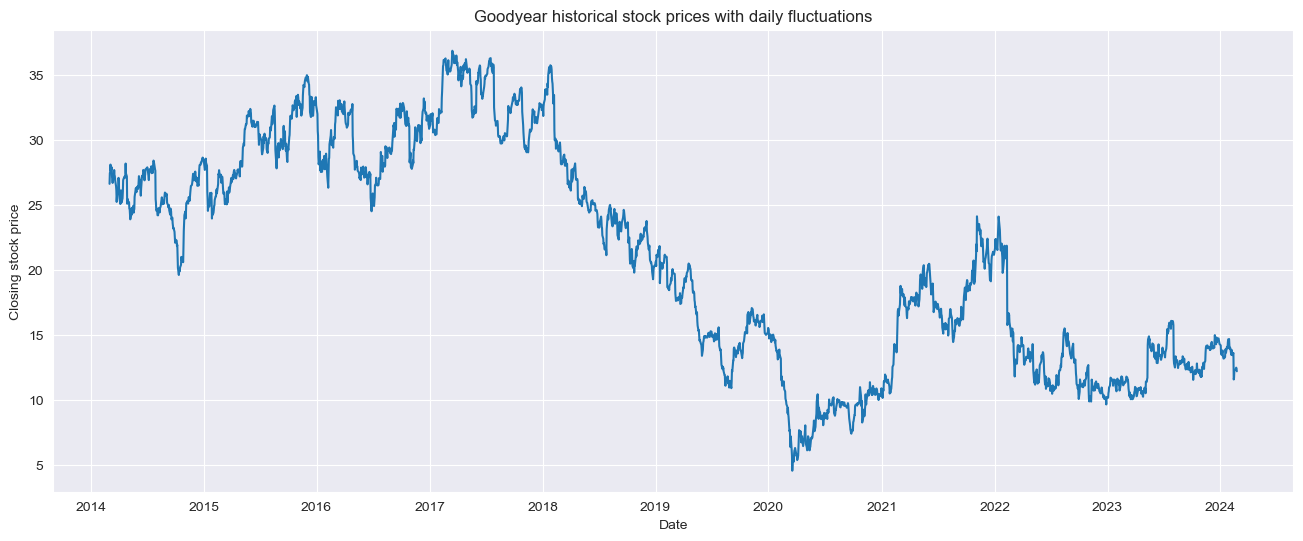

In [165]:
# overall impression of stock market performance over the years
plt.figure(figsize=(16,6))
sns.lineplot(x="date", y="GT",
             data=marketstack_filtered)

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices with daily fluctuations')

Text(0.5, 1.0, 'Goodyear historical stock prices on monthly frequency using asfreq()')

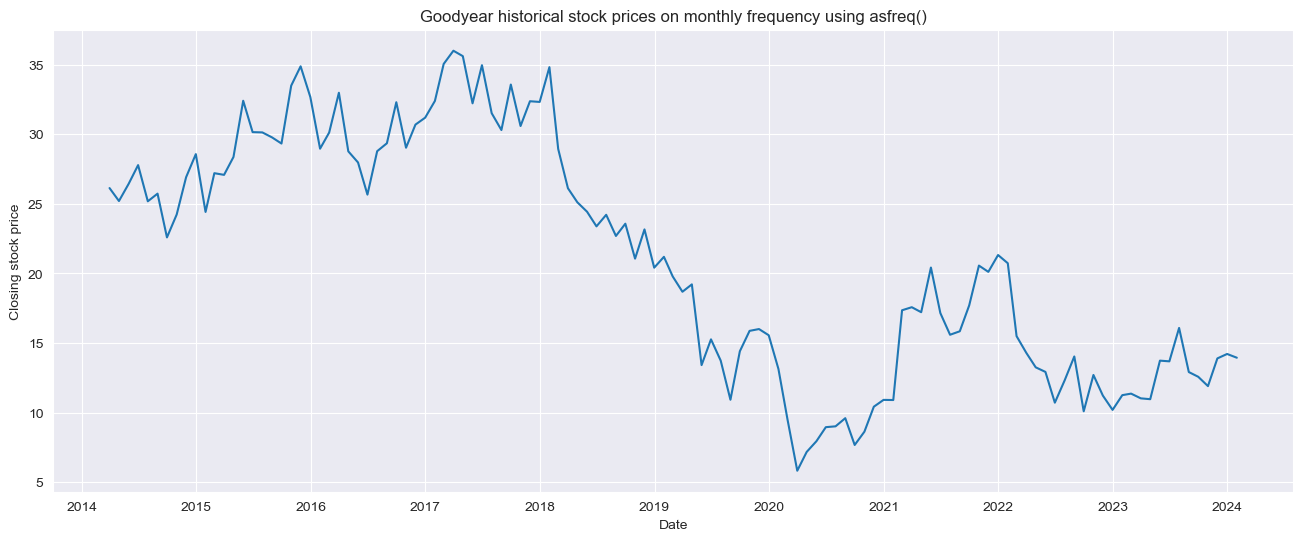

In [166]:
# overall impression of stock market performance over the years on monthly frequency
plt.figure(figsize=(16,6))
sns.lineplot(x="date", y="GT",
             data=marketstack_filtered.asfreq('ME', method='bfill'))

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices on monthly frequency using asfreq()')

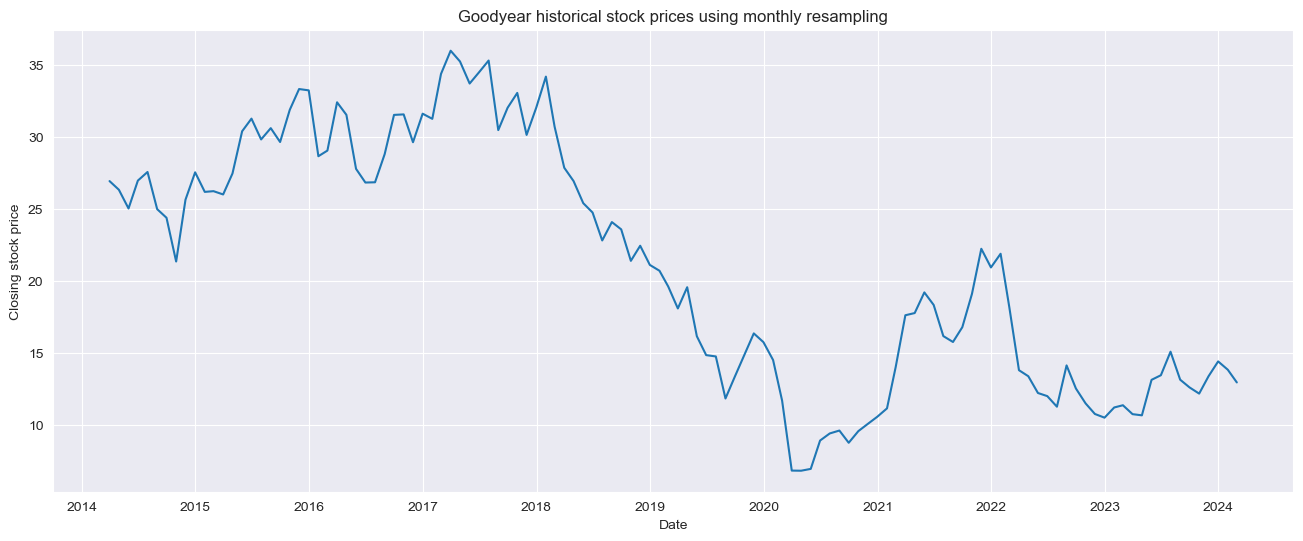

In [167]:
# Use resample instead of asfreq, how does it differ ?
freq = 'ME'
data = marketstack_filtered.resample(freq).mean().dropna()
plt.figure(figsize=(16,6))
sns.lineplot(x="date", 
             y="GT",
             data=data)

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices using monthly resampling')
plt.show()

In [168]:
# prepare dataset to compare GY stock with overall stock market NDAQ
data = marketstack_clean[marketstack_clean['symbol'].isin(['GT'])]
data = data[['dividend']]
data.head()

,dividend
date,
2014-03-03,0.0
2014-03-04,0.0
2014-03-05,0.0
2014-03-06,0.0
2014-03-07,0.0


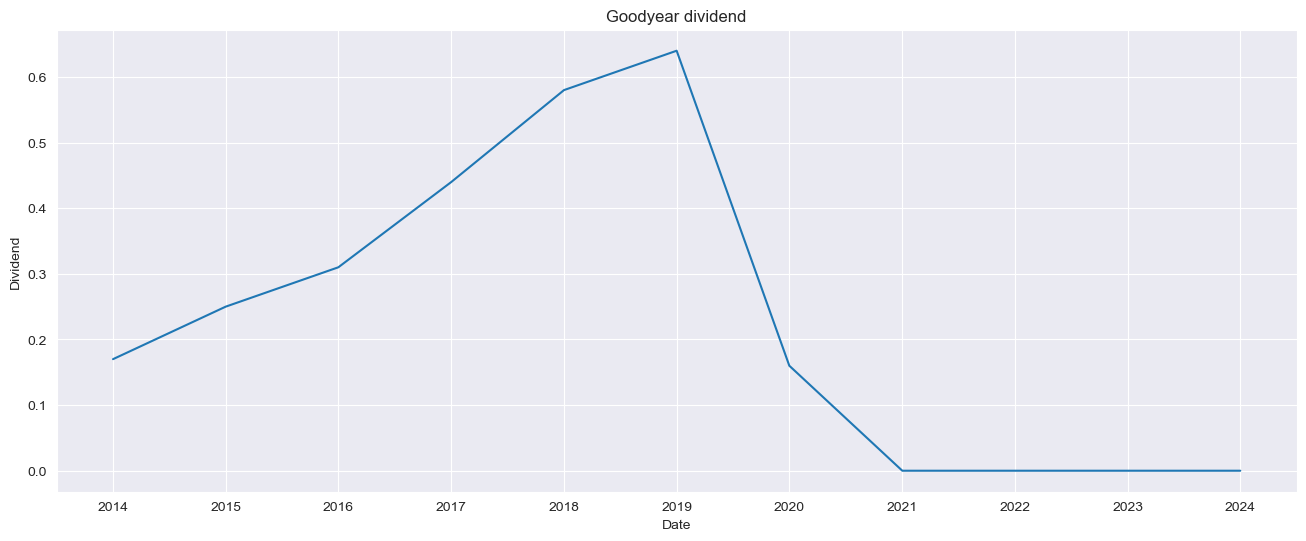

In [169]:
# prepare dividend dataset
data = marketstack_clean[marketstack_clean['symbol'].isin(['GT'])]
data = data[['dividend']]

freq = 'YS'
data = data['dividend'].resample(freq).sum()
plt.figure(figsize=(16,6))
sns.lineplot(data=data)

plt.ylabel('Dividend')
plt.xlabel('Date')
plt.title('Goodyear dividend')
plt.show()

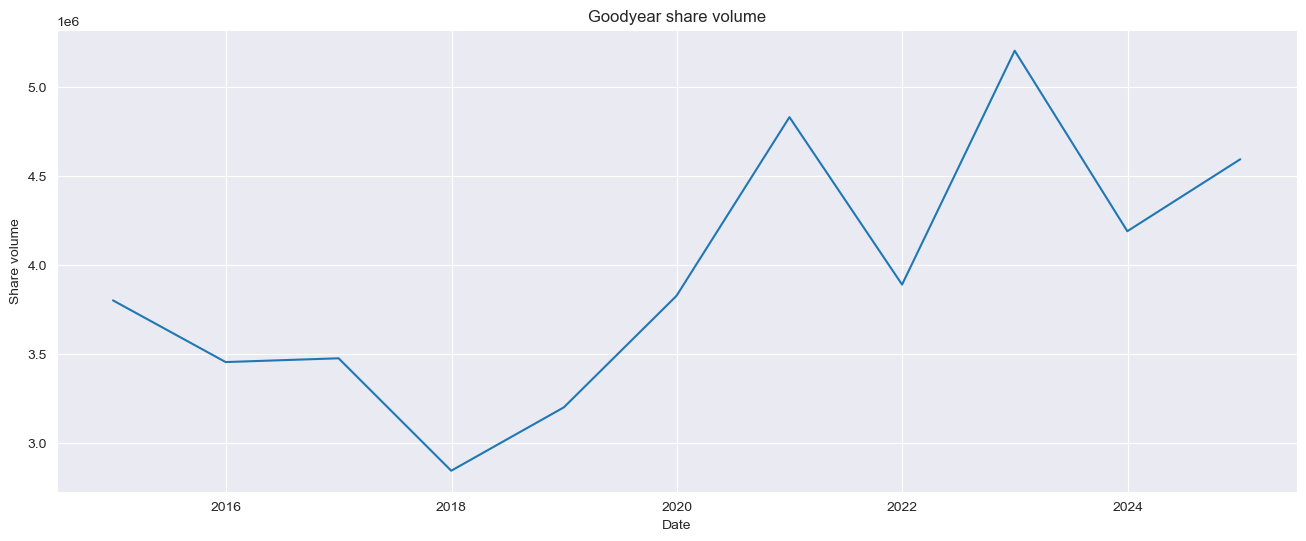

In [170]:
# prepare dividend dataset
data = marketstack_clean[marketstack_clean['symbol'].isin(['GT'])]
data = data[['volume']]

freq = 'YE'
data = data['volume'].resample(freq).mean()
plt.figure(figsize=(16,6))
sns.lineplot(data=data)

plt.ylabel('Share volume')
plt.xlabel('Date')
plt.title('Goodyear share volume')
plt.show()

>Resampled with aggregate mean gives a smoother cleaner result

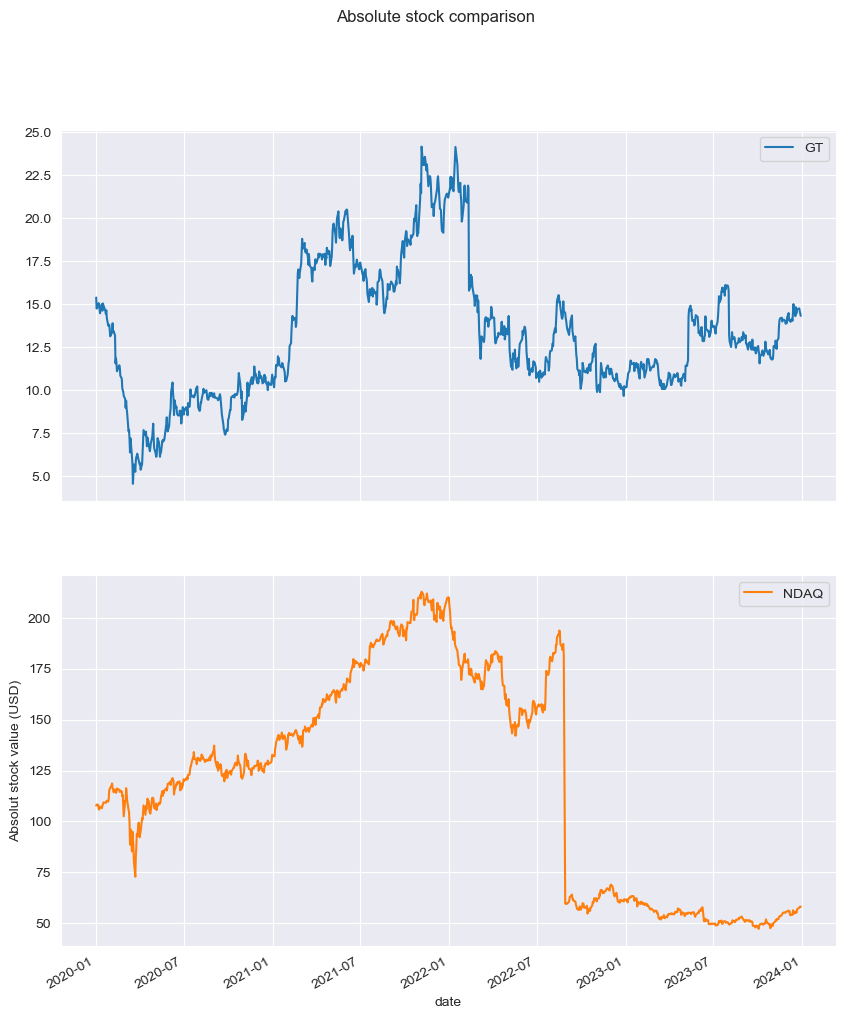

In [171]:
marketstack_filtered['2020':'2023'].plot(subplots=True, figsize=(10,12))
plt.suptitle('Absolute stock comparison')
plt.ylabel('Absolut stock value (USD)')
plt.show()

#### 1.2 Shifting and lags
We can shift index by desired number of periods with an optional time frequency. This is useful when comparing the time series with a past of itself

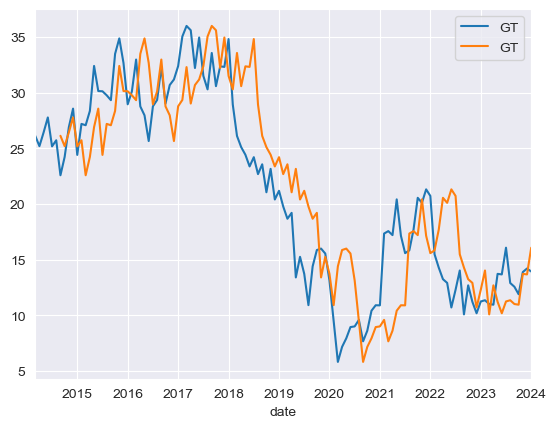

In [172]:
marketstack_filtered['GT'].asfreq('ME', method='bfill').plot(legend=True)
shifted = marketstack_filtered['GT'].asfreq('ME', method='bfill').shift(6).plot(legend=True)
shifted.legend(['GY','GY lagged by 6 months'])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## 2. Finance and Statistics

#### 2.1 Percent change
When we measure stock prices, we want to look at the trend of returns, meaning how stock prices changes from one day to the next

In [173]:
marketstack_pct = marketstack_filtered.pct_change(fill_method=None).dropna()

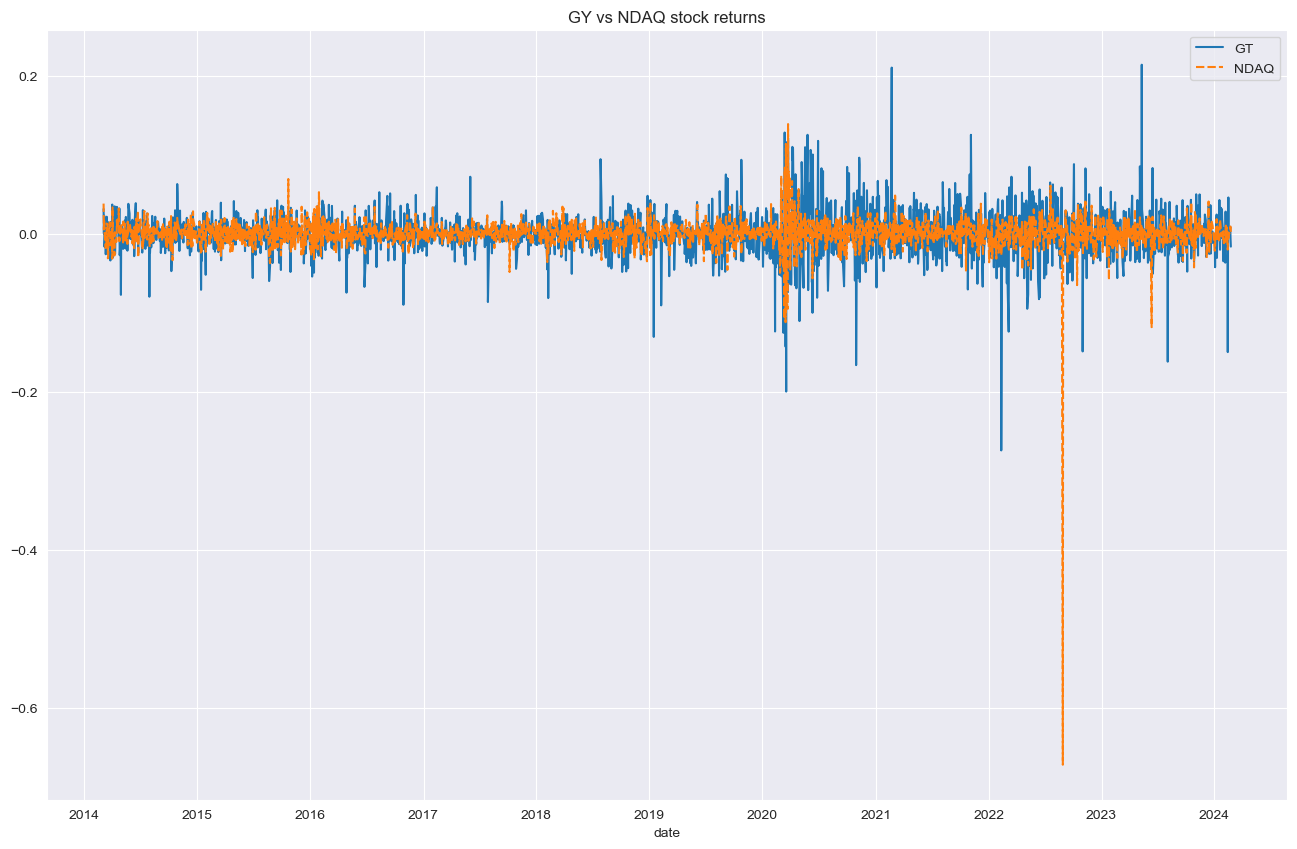

In [174]:
# calculate percentage change 
data = marketstack_filtered.pct_change(fill_method=None).dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data)
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY vs NDAQ stock returns')
plt.show()

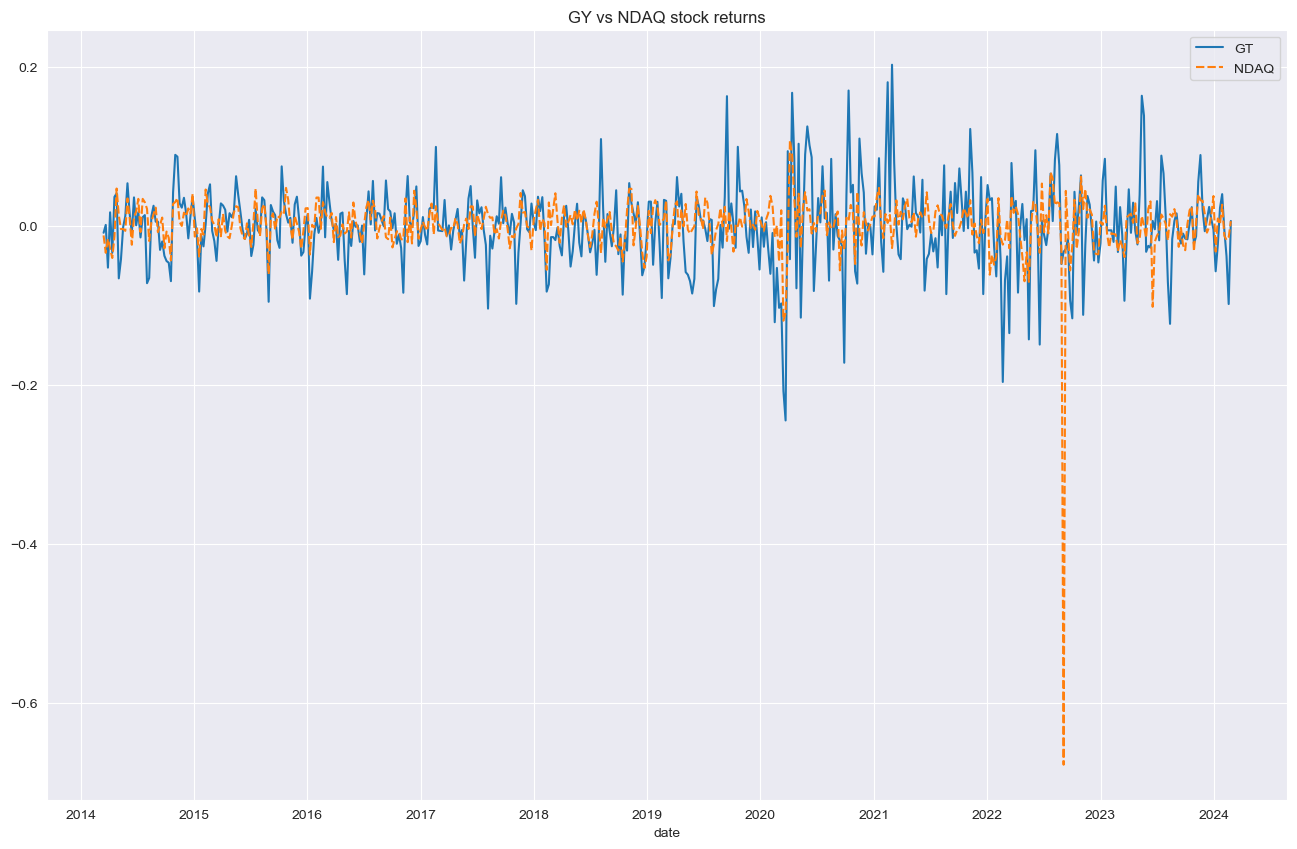

In [175]:
# calculate percentage change after resampling to weekly level
freq = 'W'
data = marketstack_filtered.resample(freq).mean()
data = data.pct_change(fill_method=None).dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data)
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY vs NDAQ stock returns')
plt.show()

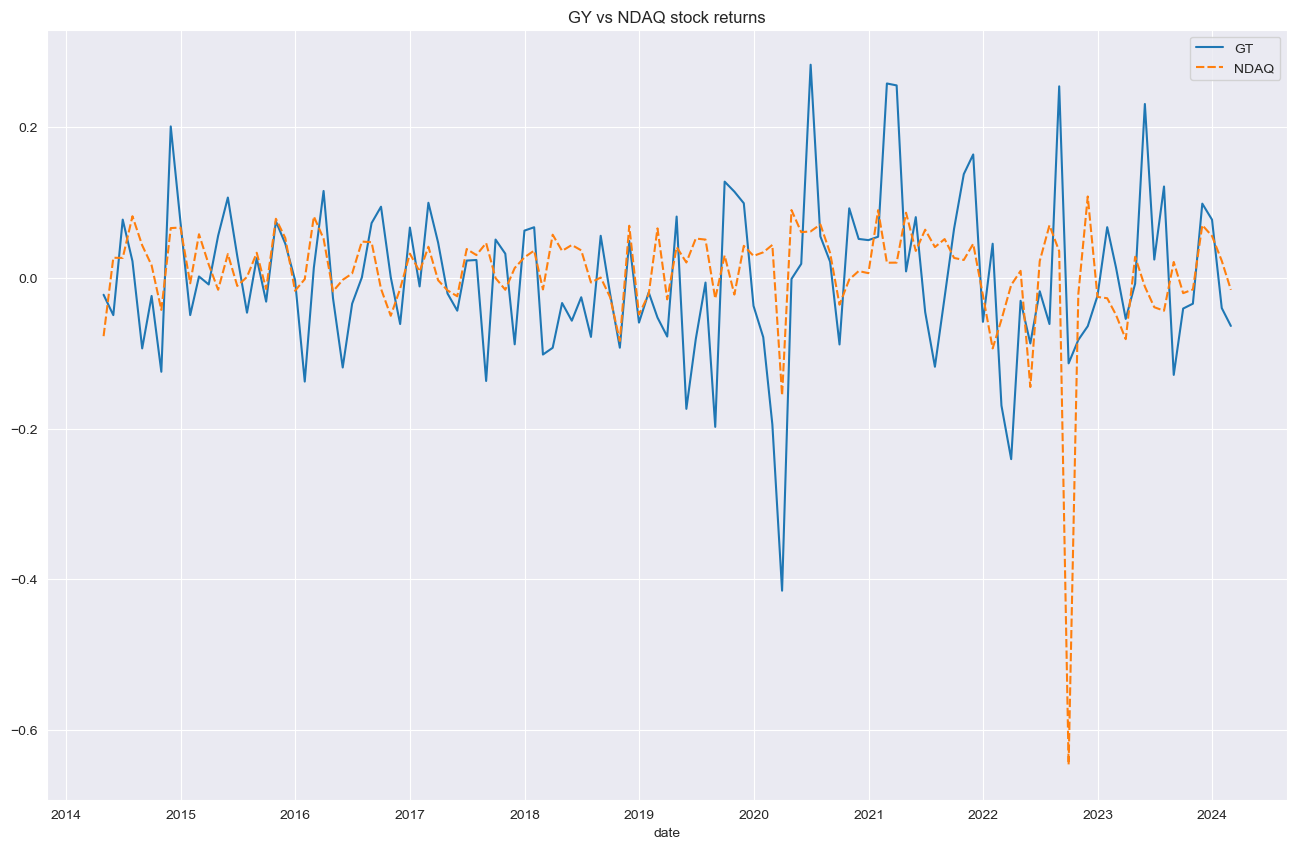

In [176]:
# calculate percentage change after resampling to weekly level
freq = 'ME'
data = marketstack_filtered.resample(freq).mean()
data = data.pct_change(fill_method=None).dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data)
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY vs NDAQ stock returns')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


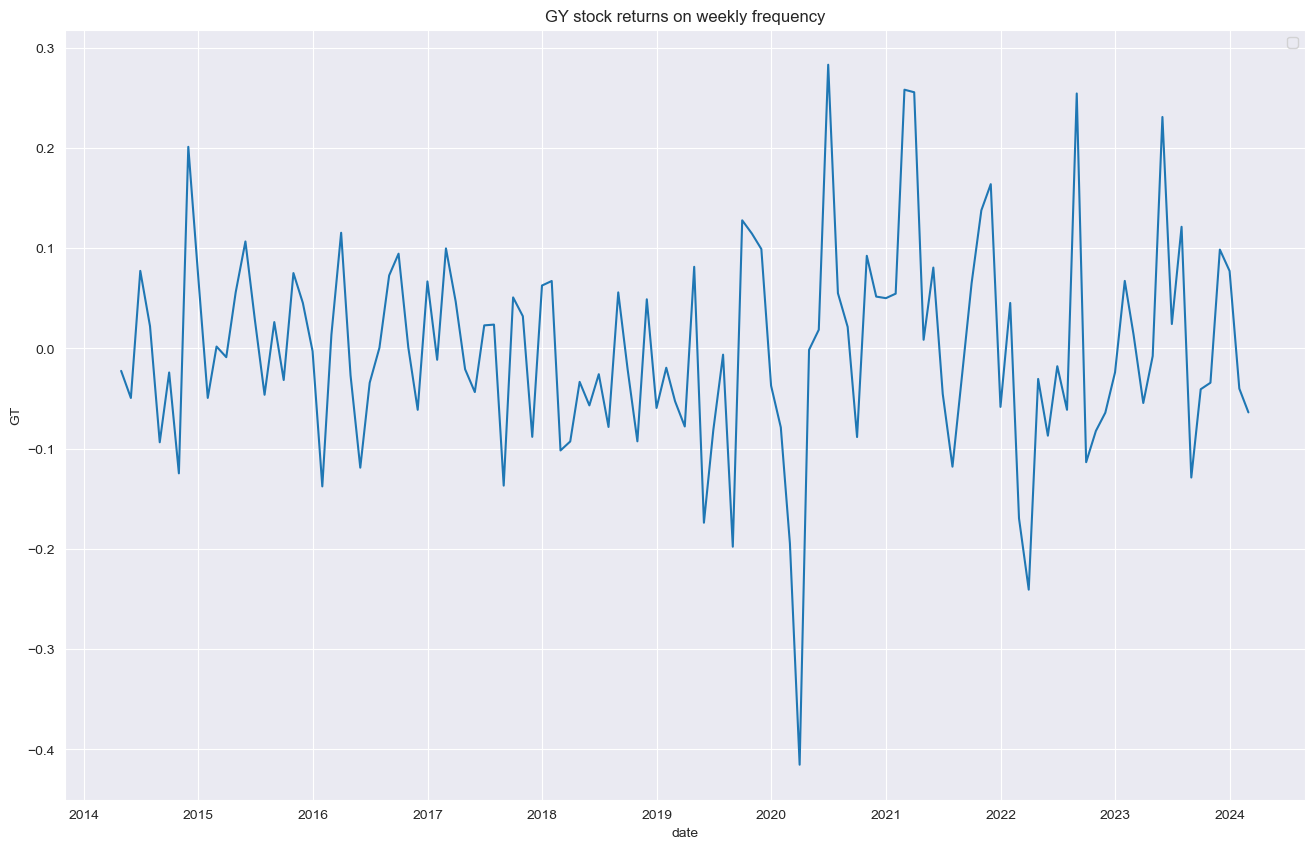

In [177]:
# calculate percentage change
plt.figure(figsize=(16,10))
sns.lineplot(data=data['GT'])
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY stock returns on weekly frequency')
plt.show()

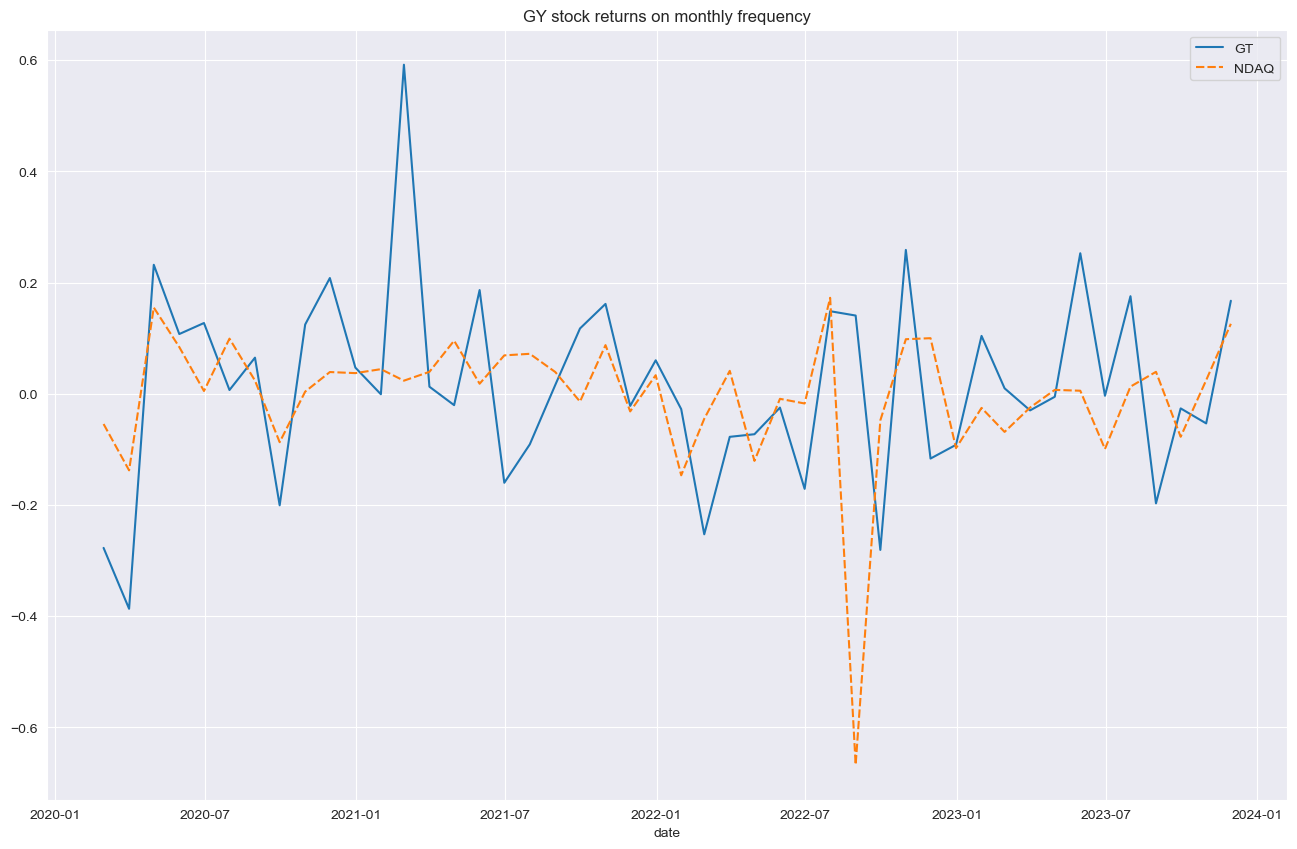

In [178]:
# calculate percentage change
data = marketstack_filtered['2020':'2023'].asfreq('ME', method='bfill').dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data.pct_change())
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY stock returns on monthly frequency')
plt.show()

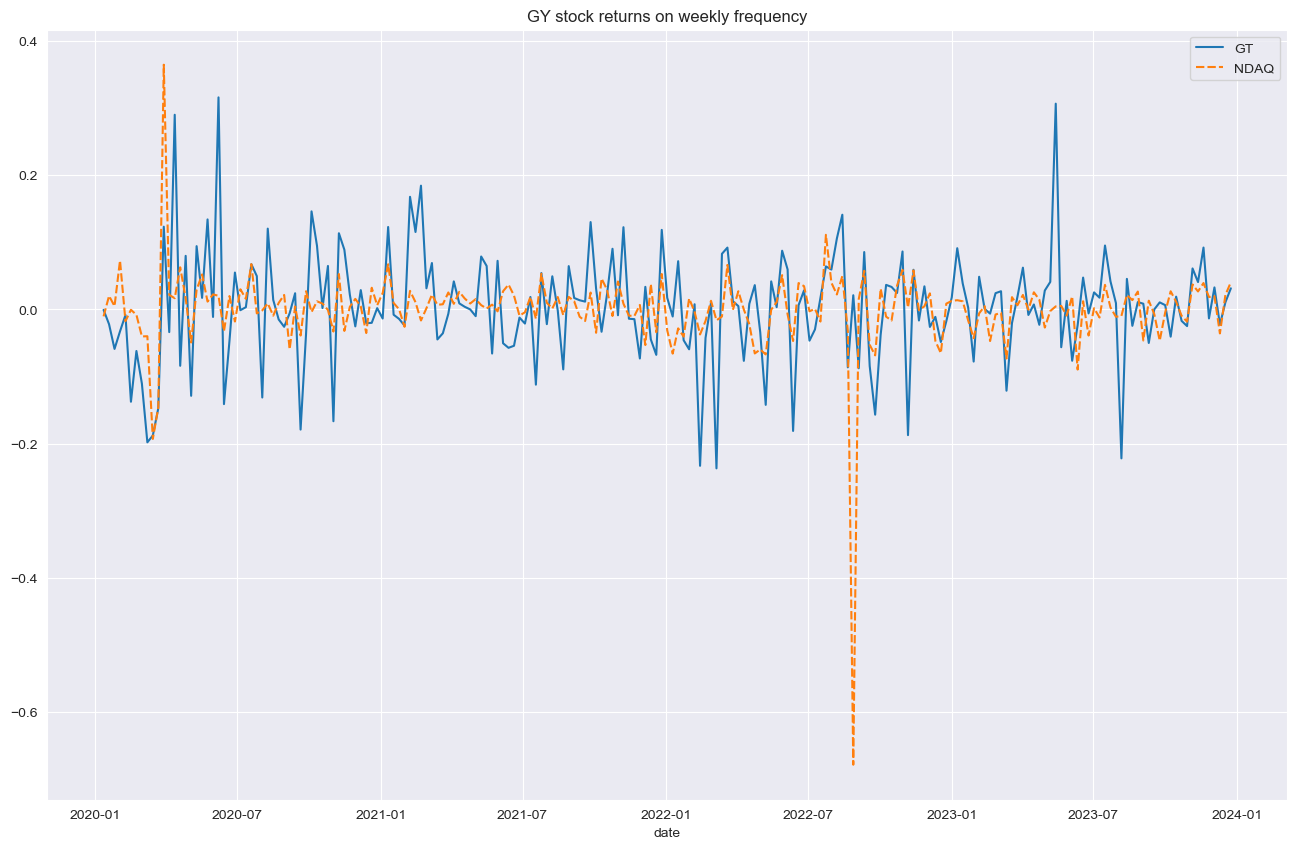

In [179]:
# calculate percentage change
data = marketstack_filtered['2020':'2023'].asfreq('W', method='bfill').dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data.pct_change())
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY stock returns on weekly frequency')
plt.show()

Correlation of stocks and interest rates:  0.0029358201482008435


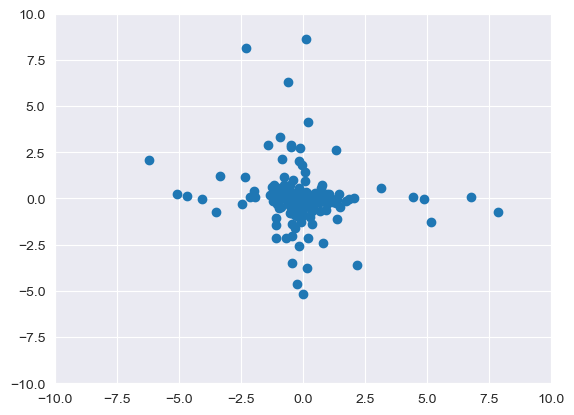

In [180]:
# Compute correlation between 2 stocks
returns = marketstack_filtered['2020':'2024'].rolling(30).mean()
returns = returns.resample('W').mean()
returns = returns.diff()
returns = returns.pct_change().dropna()
correlation = returns['GT'].corr(returns['NDAQ'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
print("Correlation of stocks and interest rates: ", correlation)

# Make scatter plot
plt.scatter(returns['GT'], returns['NDAQ'])
plt.show()

|#### 2.2 Absolute change in successive rows

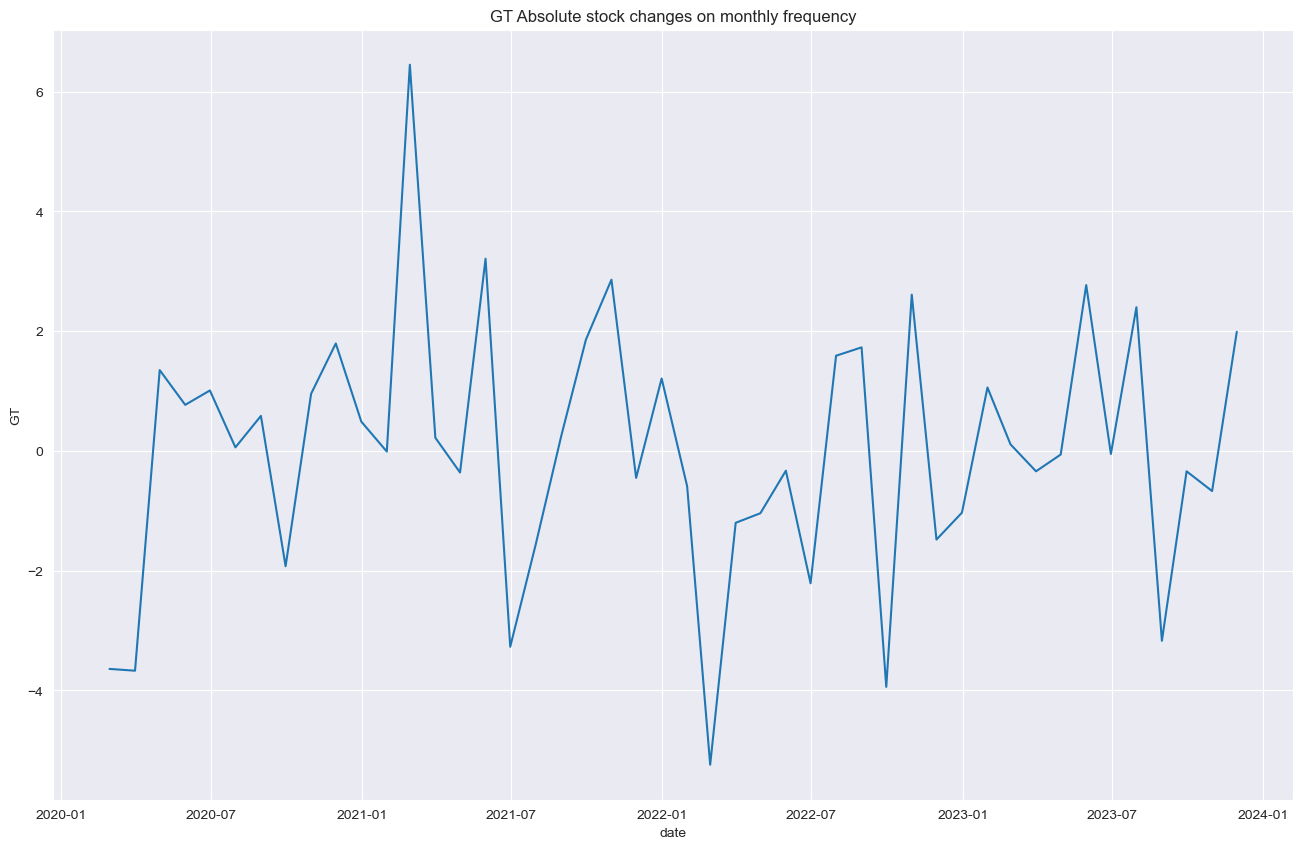

In [181]:
# calculate percentage change
data = marketstack_filtered['2020':'2023'].asfreq('ME', method='bfill').dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data['GT'].diff())
# plt.legend(bbox_to_anchor=(1,1))
plt.title('GT Absolute stock changes on monthly frequency')
plt.show()

In [182]:
# Run regression over 2 stock markets

# Compute correlation between 2 stocks
returns = marketstack_filtered['2020':'2024'].rolling(30).mean()
returns = returns.resample('MS').mean()
returns = returns.pct_change().dropna()
correlation = returns['GT'].corr(returns['NDAQ'])
print("Correlation of stocks and interest rates: {}".format(correlation))

# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(returns, columns=['GT'])

# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)

# Regress y on dfx1
result = sm.OLS(returns['NDAQ'],dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())


Correlation of stocks and interest rates: 0.3104069134918247
                            OLS Regression Results                            
Dep. Variable:                   NDAQ   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.905
Date:                Sat, 02 Mar 2024   Prob (F-statistic):             0.0318
Time:                        16:19:06   Log-Likelihood:                 46.774
No. Observations:                  48   AIC:                            -89.55
Df Residuals:                      46   BIC:                            -85.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

> R-squared is very low at 0.096, these 2 time series does not seem to be correlated

#### 2.3 Comaring two or more time series
We will compare 2 time series by normalizing them. This is achieved by dividing each time series element of all time series by the first element. This way both series start at the same point and can be easily compared.

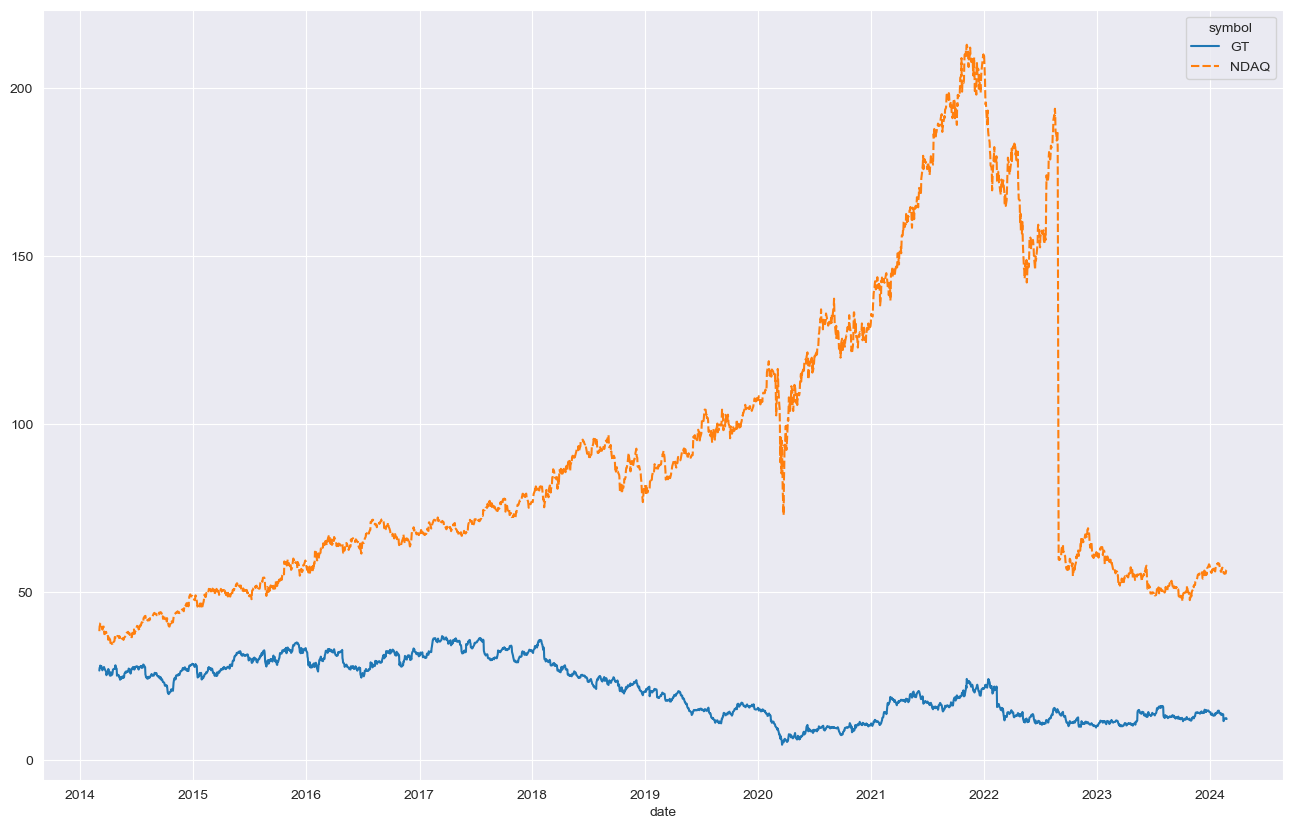

In [183]:
# Plotting before normalization
plt.figure(figsize=(16,10))
sns.lineplot(marketstack_filtered)
plt.show()

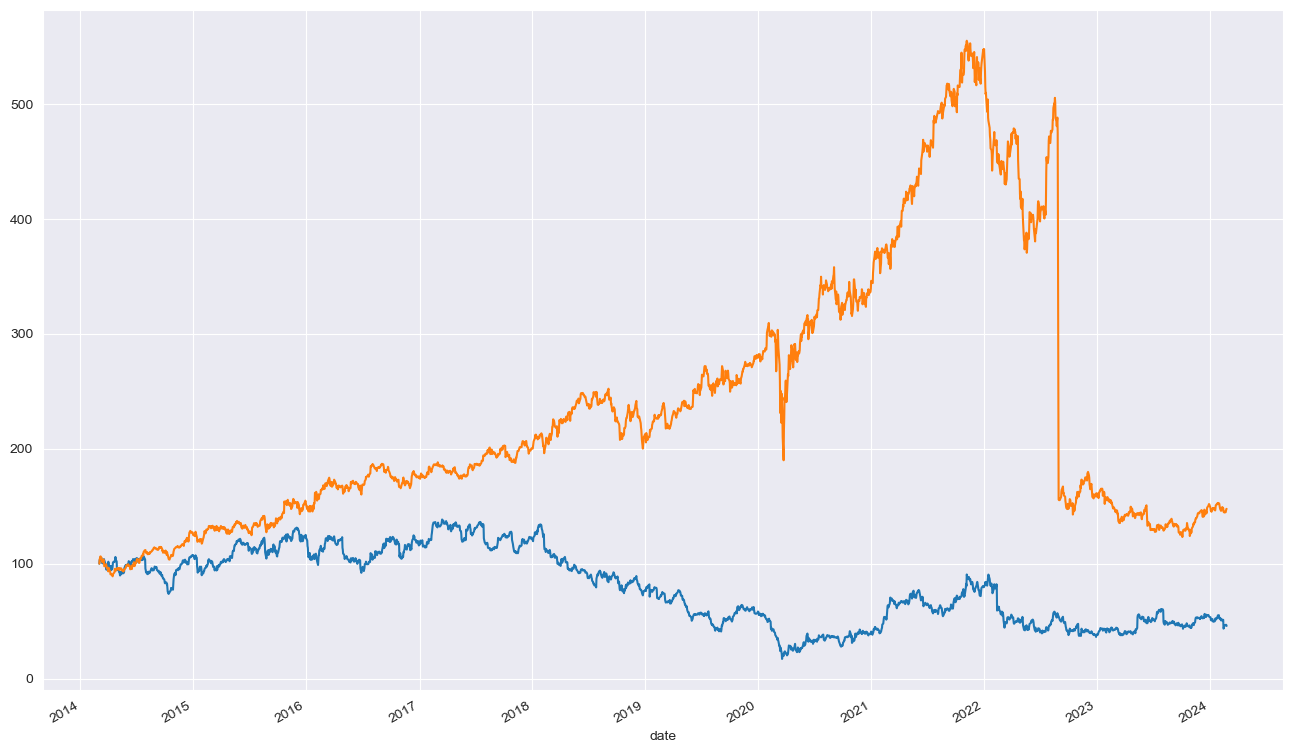

In [184]:
# Normalizing and comparison
# Both stocks start from 100
plt.figure(figsize=(16,10))
normalized_gy = marketstack_filtered['GT'].div(marketstack_filtered['GT'].iloc[0]).mul(100)
normalized_ndaq = marketstack_filtered['NDAQ'].div(marketstack_filtered['NDAQ'].iloc[0]).mul(100)
normalized_gy.plot()
normalized_ndaq.plot()
# plt.legend(['Google','Microsoft'])
plt.show()

#### 2.4 Moving average / Smoothing

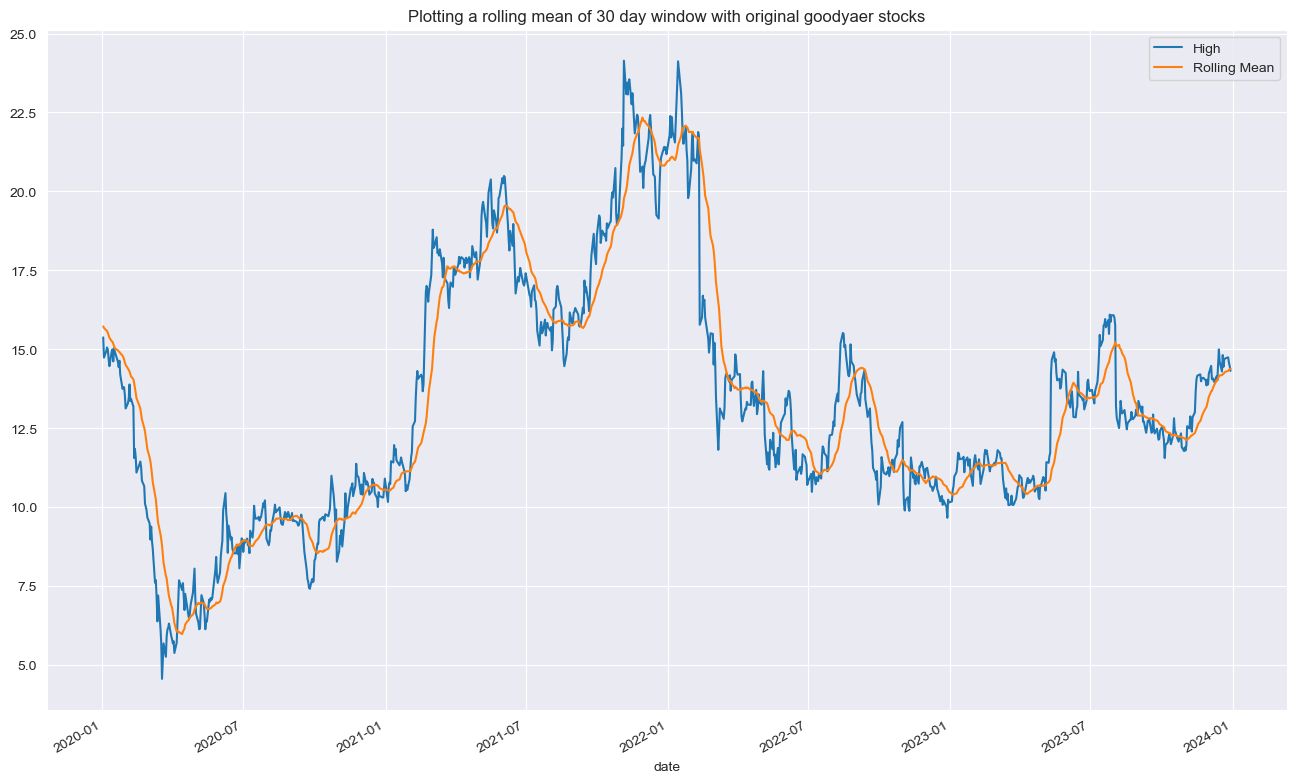

In [185]:
# Rolling window functions
plt.figure(figsize=(16,10))
rolling_gy = marketstack_filtered.rolling('30D').mean()
marketstack_filtered['2020':'2023']['GT'].plot()
rolling_gy['2020':'2023']['GT'].plot()
plt.legend(['High','Rolling Mean'])
plt.title('Plotting a rolling mean of 30 day window with original goodyaer stocks')
plt.show()

Now, observe that rolling mean plot is a smoother version of the original plot.

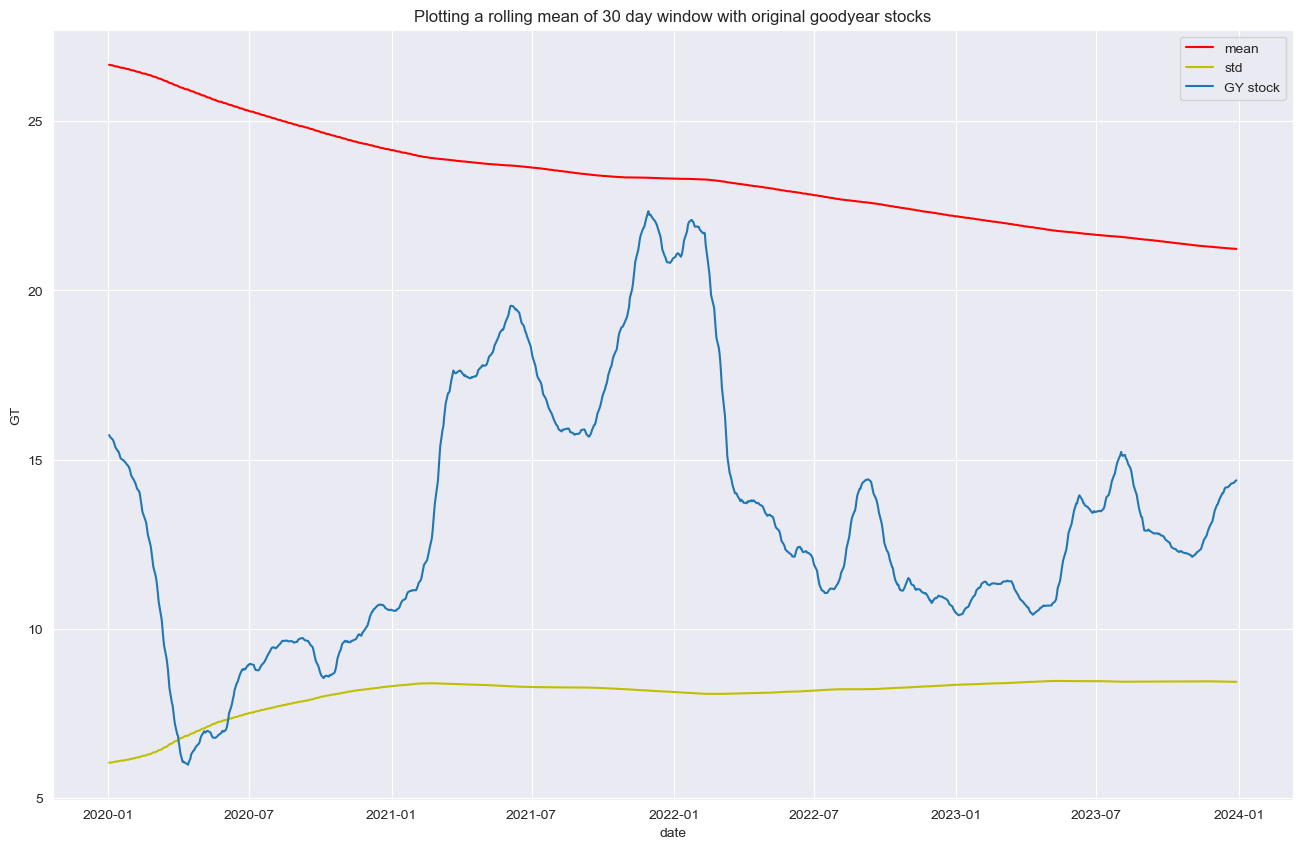

In [186]:
# expanding window functions (like an accumulative mean calculation)
plt.figure(figsize=(16,10))
gy_mean = marketstack_filtered['GT'].expanding().mean()
gy_std = marketstack_filtered['GT'].expanding().std()
sns.lineplot(gy_mean['2020':'2023'], label='mean', color='r')
sns.lineplot(gy_std['2020':'2023'], label='std', color='y')
sns.lineplot(rolling_gy['2020':'2023']['GT'], label='GY stock')
plt.legend()
plt.title('Plotting a rolling mean of 30 day window with original goodyear stocks')
plt.show()

In [187]:
# Build enhanced smoothed dataset showing returns
# Remove noice from daily fluctuations by calculating a day 30 moving average

# calculate a rolling 30 day moving average to get rid of noice
marketstack_ma = marketstack_filtered.rolling('30D').mean()

# resample to monthly level
freq='ME'
marketstack_month = marketstack_ma.resample(freq).mean()

# calculate percentage changes
marketstack_pct = marketstack_month.pct_change().dropna()
marketstack_pct.head()

symbol,GT,NDAQ
date,,
2014-04-30,-0.031292,-0.064785
2014-05-31,-0.028987,-0.016202
2014-06-30,0.015474,0.026140
2014-07-31,0.054953,0.049590
2014-08-31,-0.050938,0.071543


In [53]:
marketstack_ma 

symbol,GT,NDAQ
date,,
2014-03-03,26.640000,38.350000
2014-03-04,27.060000,39.085000
2014-03-05,27.203333,39.403333
2014-03-06,27.432500,39.727500
2014-03-07,27.478000,39.940000
...,...,...
2024-02-16,13.607727,57.140455
2024-02-20,13.532381,57.045238
2024-02-21,13.456190,56.944286


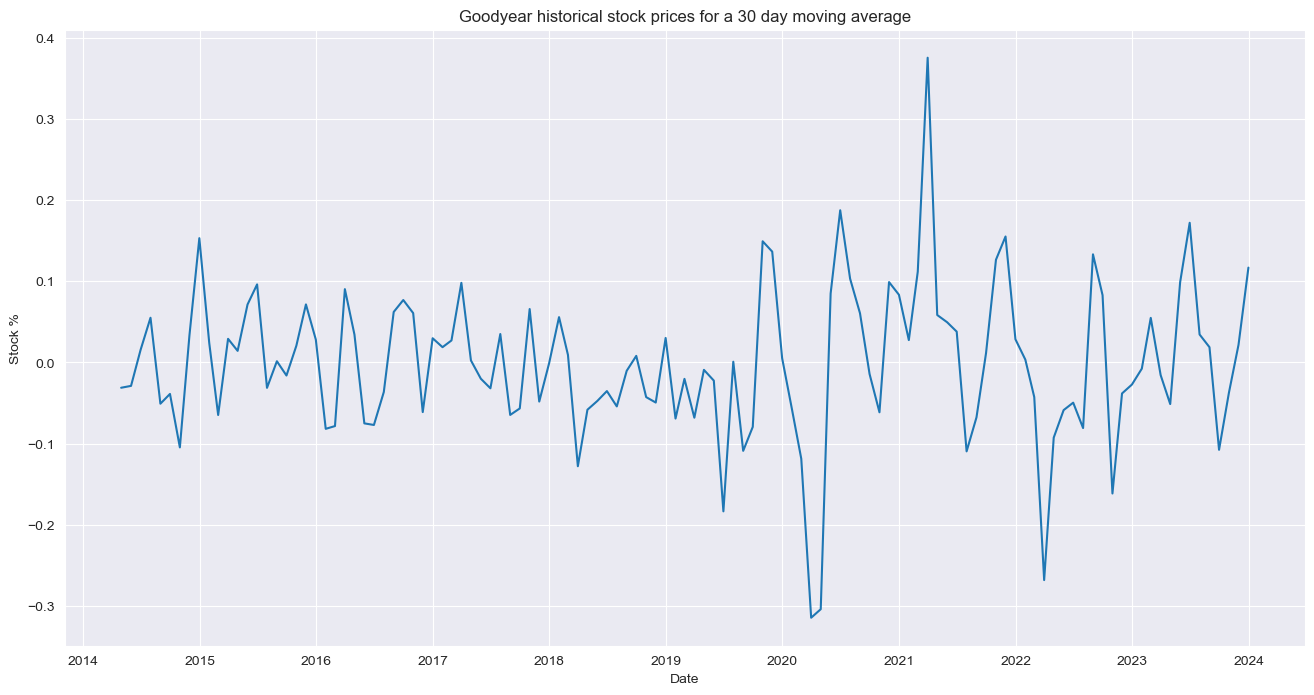

In [54]:

returns = marketstack_pct['2014':'2023']
plt.figure(figsize=(16,8))
sns.lineplot(
    x=returns.index,
    y=returns['GT'])
    # hue=data.index.year,
    # palett='viridis_r')

plt.ylabel('Stock %')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices for a 30 day moving average')
plt.show()

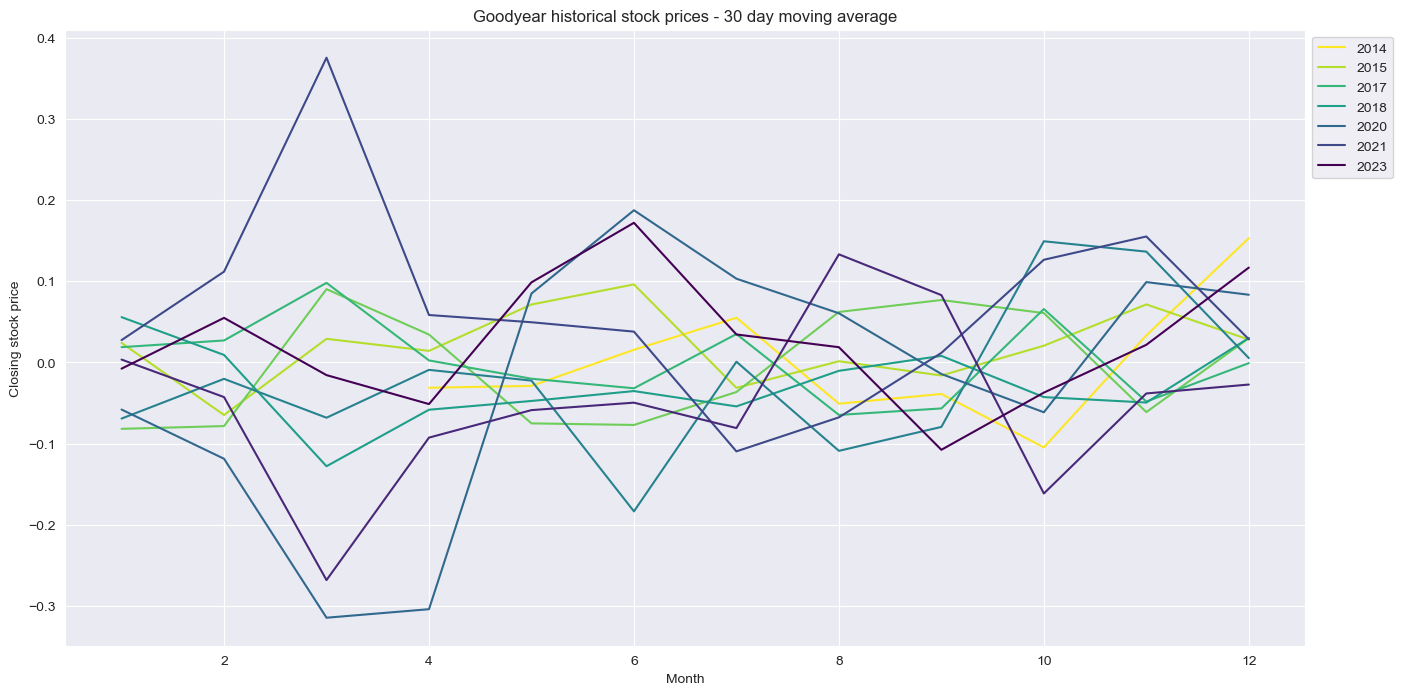

In [55]:
# plot the timeseries data
plt.figure(figsize=(16,8))
sns.lineplot(
    x=returns.index.month, 
    y=returns.GT,
    hue=returns.index.year,
    palette='viridis_r')

plt.ylabel('Closing stock price')
plt.xlabel('Month')
plt.title('Goodyear historical stock prices - 30 day moving average')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [ ]:
# Change frequency to month and calculate percentage change
data = returns['2021':'2024']
plt.figure(figsize=(14,8))
sns.lineplot(
    x=data.index, 
    y=data['GT'],
    hue=data.index.year,
    palette='viridis_r')

plt.ylabel('Closing stock price')
plt.xlabel('Day of month')
plt.title('Goodyear historical stock prices percentage change')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

# ARIMA analysis

# Step 1: White noice

White noise has...
- Constant mean
- Constant variance
- Zero auto-correlation at all lags

Can't Forecast White Noise
A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. 
Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

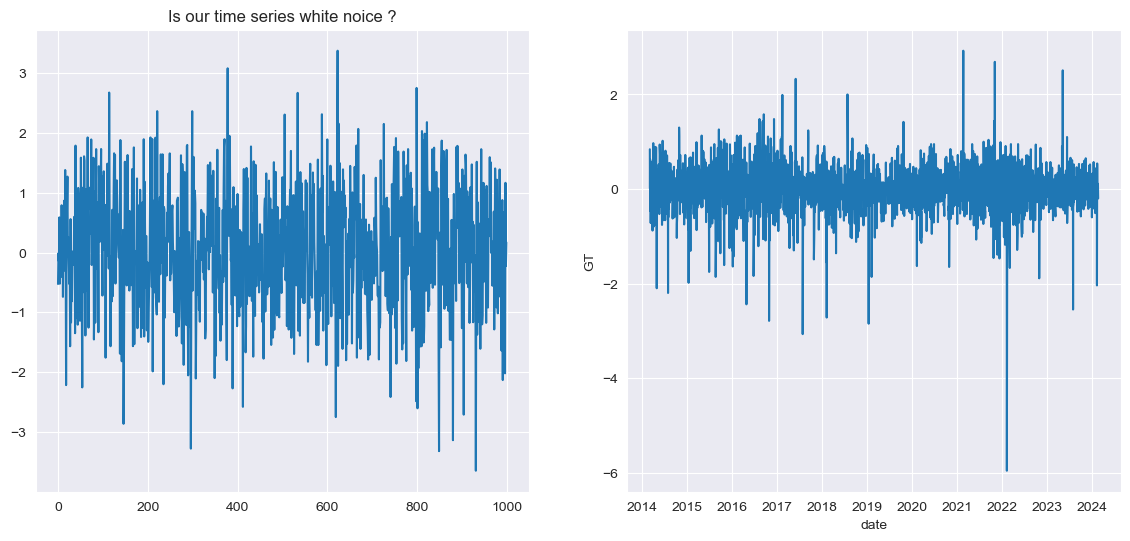

In [70]:
# Plotting white noise - example what it looks like

fig, axes = plt.subplots(1,2, figsize=(14, 6))
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
ax1 = sns.lineplot(white_noise, ax=axes[0])
ax2 = sns.lineplot(marketstack_filtered['GT'].diff(), ax=axes[1])
ax1.set_title('Example of what white noice looks like')
ax1.set_title('Is our time series white noice ?')
plt.show()

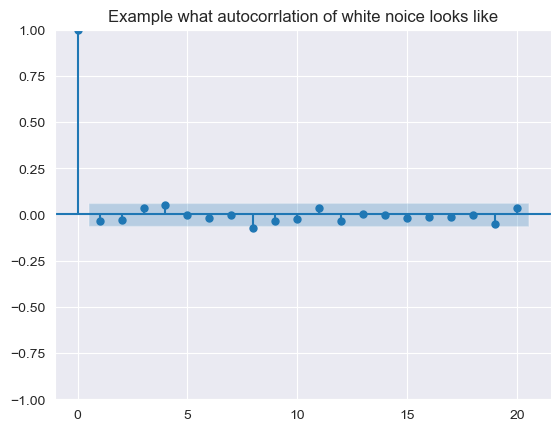

In [71]:
# Plotting autocorrelation of white noise
tsaplots.plot_acf(white_noise,lags=20)
plt.title('Example what autocorrlation of white noice looks like')
plt.show()

# Step 2. dickley fuller test - Is the time series a random walk ?
dickey fuller helps us to see if our time series is a random walk or not. If pvalue is < 5% it is not random walk and we can use it for forecasting without any transformations. If pvalue > 5%, we have to convert the time series to make it stationary first, with other .diff() or .pct_change(), however ARIMA works with diff best.

## Random walk with drift

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

Pt = Pt-1 + εt
Random walks can't be forecasted because well, noise is random.

Random Walk with Drift(drift(μ) is zero-mean)

Pt - Pt-1 = μ + εt

Regression test for random walk

Pt = α + βPt-1 + εt
Equivalent to Pt - Pt-1 = α + βPt-1 + εt

Test:

H0: β = 1 (This is a random walk)
H1: β < 1 (This is not a random walk)

Dickey-Fuller Test:

H0: β = 0 (This is a random walk)
H1: β < 0 (This is not a random walk)

In a random walk with drift, prices on average drift by mu every period. And the change in price for a random walk with drift is still white noise but with a mean of mu. So if we now think of stock prices as a random walk with drift, then the returns are still white noise, but with an average return of mu instead of zero.

To test whether a series like stock prices follows a random walk, you can regress current prices on lagged prices. If the slope coefficient, beta, is not significantly different from one, then we cannot reject the null hypothesis that the series is a random walk. However, if the slope coefficient is significantly less than one, then we can reject the null hypothesis that the series is a random walk.

**Statistical Test for Random Walk**
An identical way to do that test is to regress the difference in prices on the lagged price, and instead of testing whether the slope coefficient is 1, now we test whether it is zero.

This is called the "Dickey-Fuller" test. If you add more lagged prices on the right hand side, then it's called the Augmented Dickey-Fuller test.



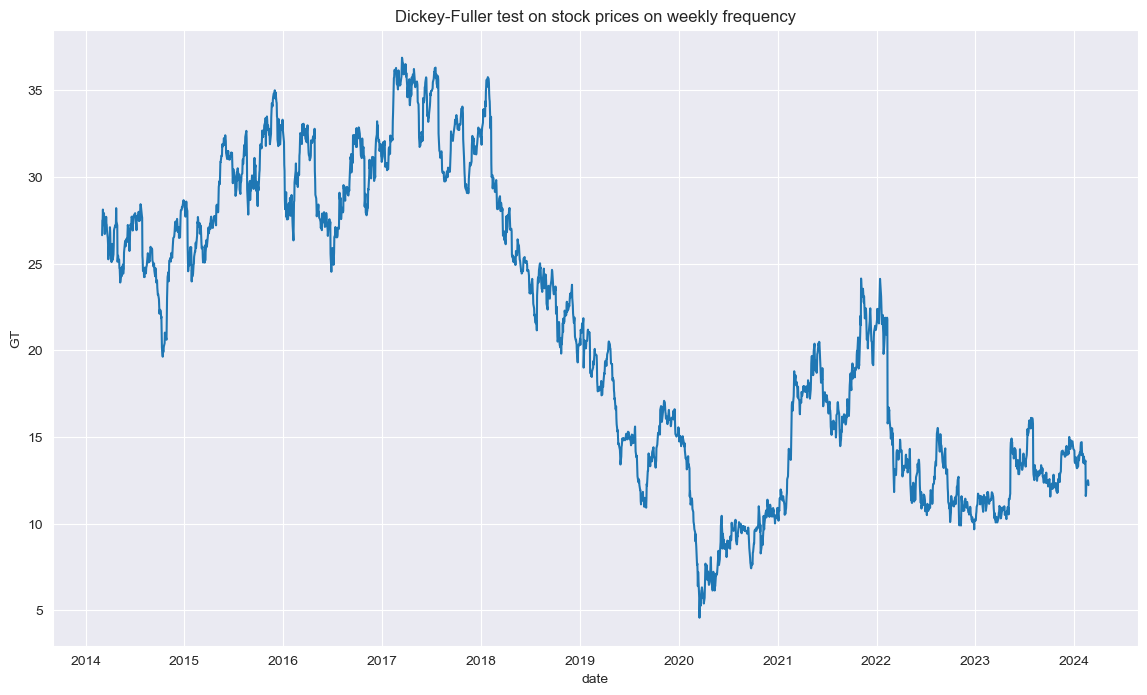


The p-value of the test on prices is: 0.5749240749125326


In [83]:
# Run adfuller test on the daily stock price data without any data transformations
plt.figure(figsize=(14,8))
sns.lineplot(marketstack_filtered['GT'])
plt.title('Dickey-Fuller test on stock prices on weekly frequency')
plt.show()

results = adfuller(marketstack_filtered['GT'])
print('\nThe p-value of the test on prices is: ' + str(results[1]))

In [84]:
def change_ticker(ax):

    # change axis to YYYYMM
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
    ax.tick_params(rotation=90, axis='x') 

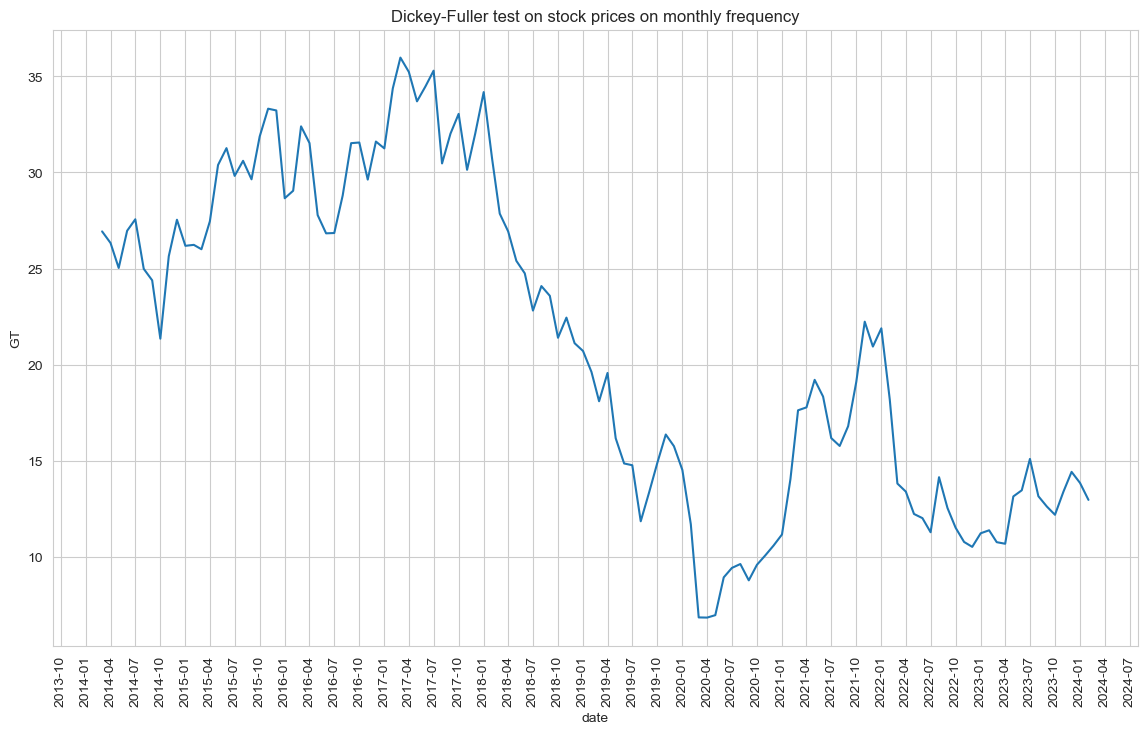


The p-value of the test on prices is: 0.6560111200015039


In [211]:
# try again to run dickey fuller test on time series with monthly frequency
freq = 'MS'
marketstack_monthly = marketstack_filtered.resample(freq).mean()

# Run adfuller test on the daily stock price data without any data transformations
plt.figure(figsize=(14,8))

ax = sns.lineplot(marketstack_monthly['GT'])

ax = change_ticker(ax)

plt.title('Dickey-Fuller test on stock prices on monthly frequency')
plt.show()

results = adfuller(marketstack_monthly['GT'])
print('\nThe p-value of the test on prices is: ' + str(results[1]))

> GY stock prices without transformation is a random walk with trends as pvalue > 0.05, and cannot be used for forecasting without transformation when using ARIMA.

> If the p-value is less than 5%, we can reject the null hypothesis that the series is a random walk with 95% confidence. This is good news it means we can use the time series to forecast future results

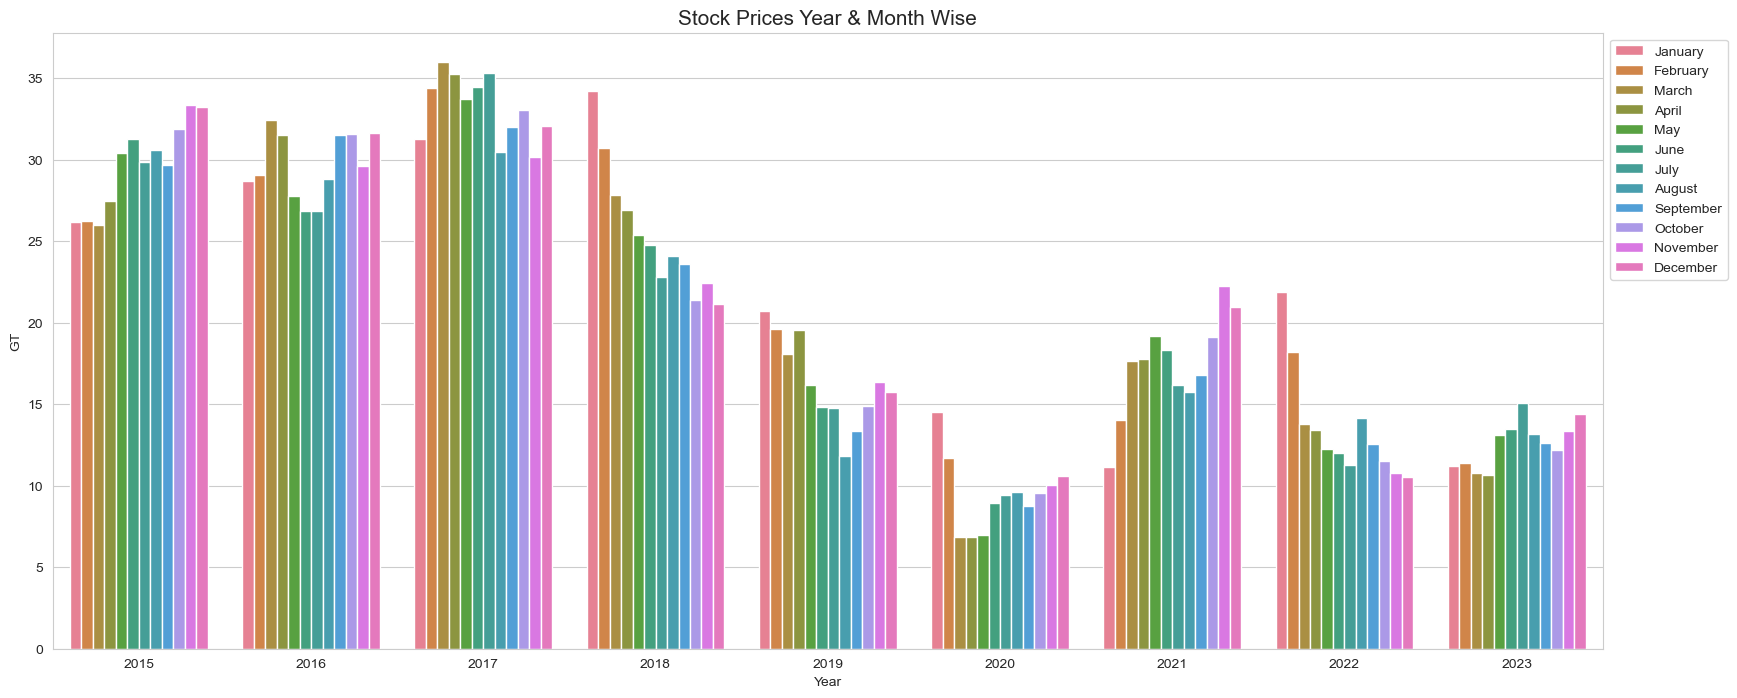

In [210]:
data = marketstack_monthly['2015':'2023'].copy(deep=True)
data['Year'] = marketstack_monthly['2015':'2023'].index.year
data['Month'] = marketstack_monthly['2015':'2023'].index.strftime('%B')
data['Quarter'] = marketstack_monthly['2015':'2023'].index.quarter
fig, ax = plt.subplots(figsize=(20,8))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="GT", hue='Month',data=data, ax=ax)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

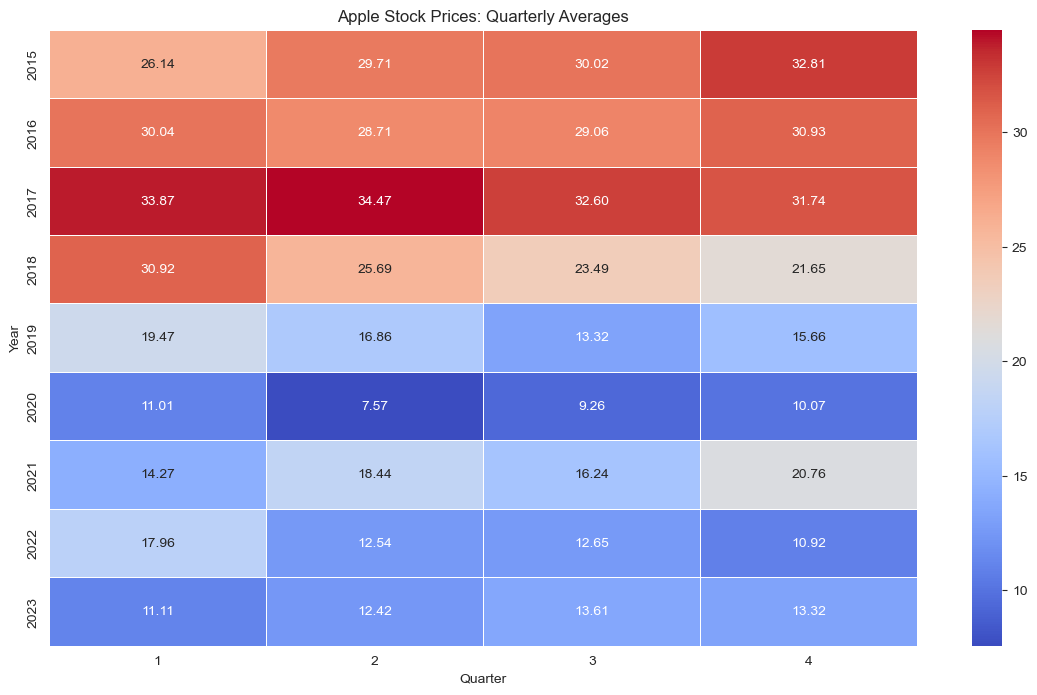

In [209]:
quarter = data.groupby(["Year", "Quarter"])["GT"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Apple Stock Prices: Quarterly Averages")
plt.show()

Decomposition of Time Series

<Figure size 3000x1200 with 0 Axes>

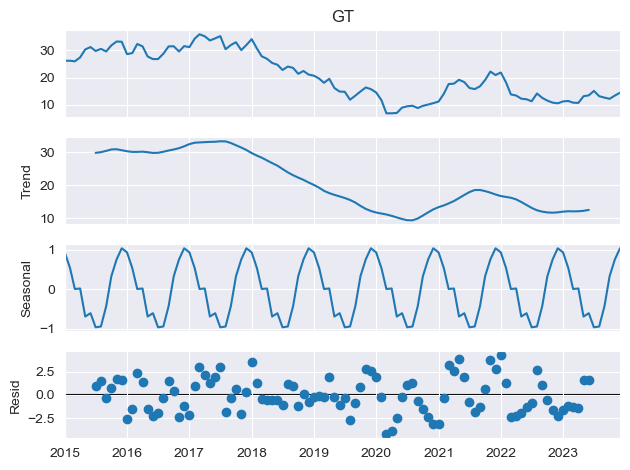

In [214]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

plt.figure(figsize=(30,12))
decomposed_series = sd(data['GT'])
decomposed_series.plot()
plt.show()

<Axes: xlabel='date'>

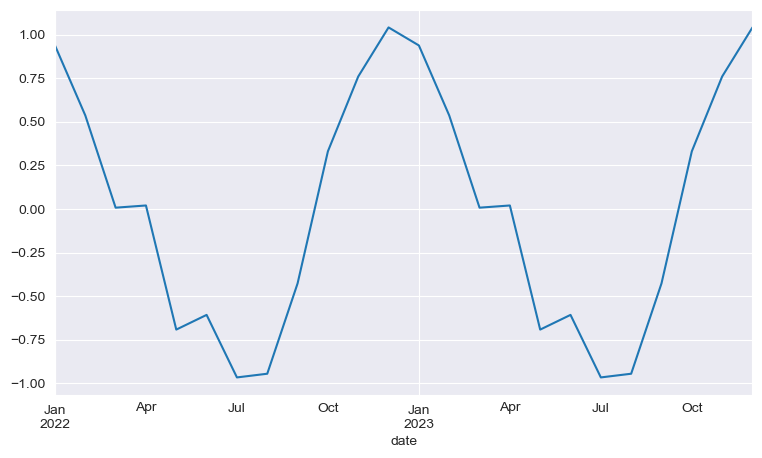

In [216]:
#Drilling Down and Observing Seasonality
fig = plt.figure(figsize=(9,5))
decomposed_series.seasonal['2022':'2023'].plot()

# Step 3: Stationarity
If a time series is a random walk, convert it into stationary dataset first before we can do any forecasting when using the ARIMA model.

**What means Stationarity?**
It means that the joint distribution of the observations do not depend on time. It has no trend and autocorration is constant.

A less restrictive version of stationarity, and one that is easier to test, is weak stationarity, which just means that the mean, variance, and autocorrelations of the observations do not depend on time. In other words, for the autocorrelation, the correlation between X-t and X-(t-tau) is only a function of the lag tau, and not a function of time.

If a process is not stationary, then it becomes difficult to model. Modeling involves estimating a set of parameters, and if a process is not stationary, and the parameters are different at each point in time, then there are too many parameters to estimate. You may end up having more parameters than actual data! So stationarity is necessary for a parsimonious model, one with a smaller set of parameters to estimate.

diff() method can easily convert a non-stationary series to a stationary series.

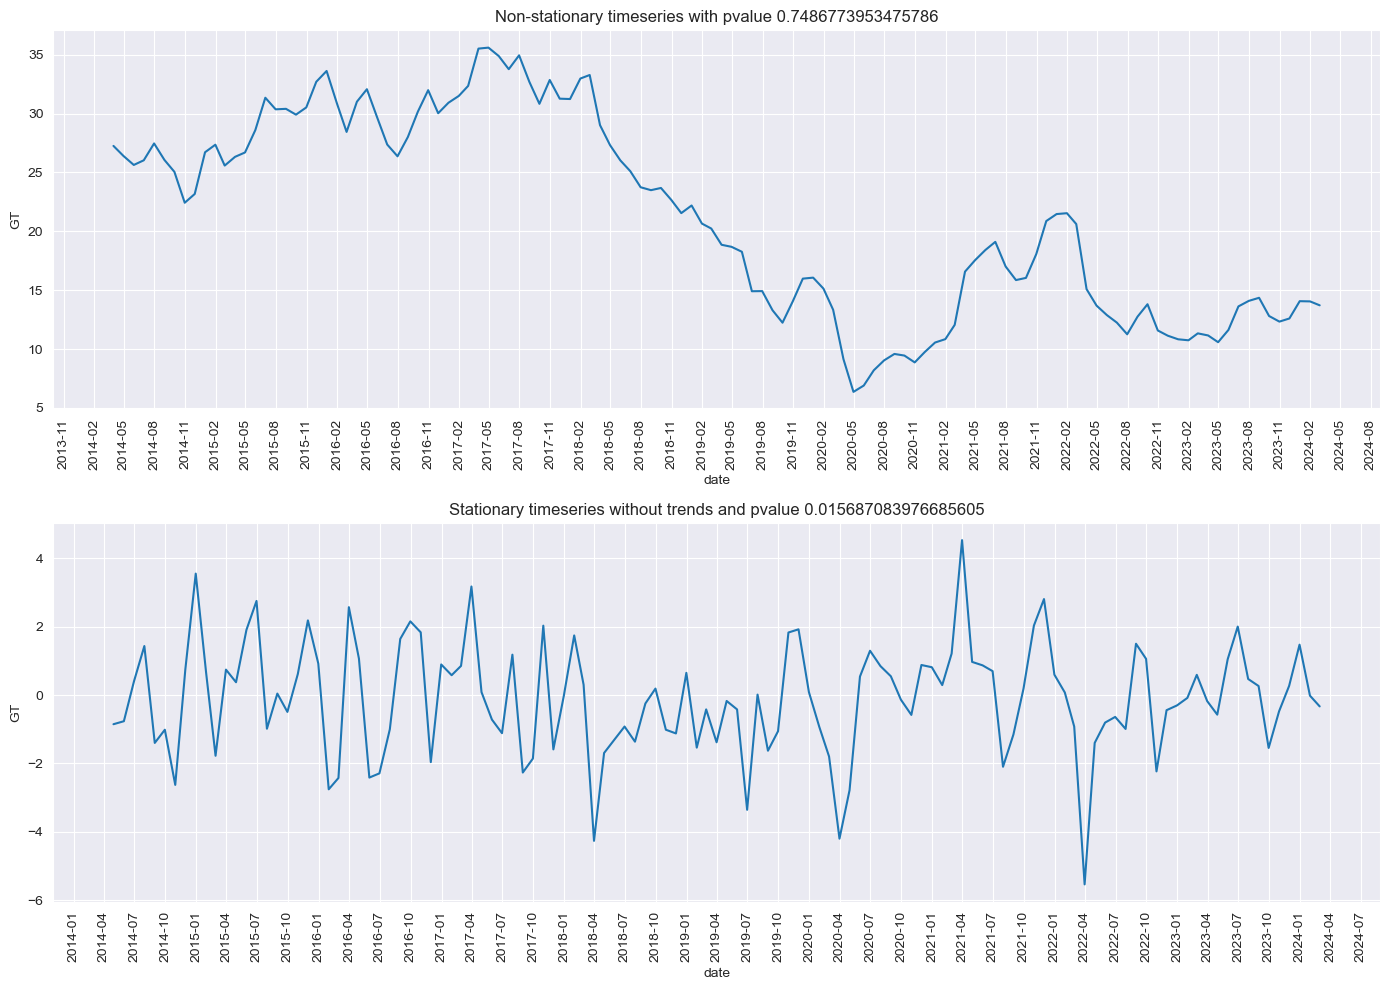

In [217]:
# example on non-stationary plot, time influence the stock prices, example pre and post covid
fig, axes = plt.subplots(2,1, figsize=(14,10))

ax1 = sns.lineplot(data=marketstack_month['GT'], ax=axes[0])
results = adfuller(marketstack_month['GT'])
ax1.title.set_text('Non-stationary timeseries with pvalue {}'.format(results[1]))
ax1 = change_ticker(ax1)

marketstack_diff = marketstack_month.diff().dropna()
ax2 = sns.lineplot(marketstack_diff['GT'], ax=axes[1])
results = adfuller(marketstack_diff['GT'])
ax2.title.set_text('Stationary timeseries without trends and pvalue {}'.format(results[1]))
ax2 = change_ticker(ax2)

plt.tight_layout()

>By seasonally adjusting the series, we eliminated the seasonal pattern in the autocorrelation function.

# Step 4: Compute ACF and PACF
To identify the ARIMA model parameters, we use ACF and PACF to help us select hyper parameters for RA or MA order.
Series must be stationary **before** we use ACF and PACF


Now that the time series is stationary, compute the sample ACF and PACF. This will provide some guidance on the order of the ARIMA model to use.

#### **Autocorrelation**
The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.

Autocorrelation is the correlation of a single time series with a lagged copy of itself. It's also called "serial correlation". Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

When you look at the correlation of say, two stocks, you should look at the correlation of their *returns*, not their levels, it makes them more comparable.

What does it mean when a series has a positive or negative autocorrelation? 
- With financial time series, when returns have a negative autocorrelation, we say it is "mean reverting". Mean reversion is a financial theory which suggests that, after an extreme price move, asset prices tend to return back to normal or average levels.
- If a series has positive autocorrelation, we say it is "trend-following".

Many hedge fund strategies are only slightly more complex versions of mean reversion and momentum strategies. Since stocks have historically had negative autocorrelation over horizons of about a week, one popular strategy is to buy stocks that have dropped over the last week and sell stocks that have gone up. For other assets like commodities and currencies, they have historically had positive autocorrelation over horizons of several months, so the typical hedge fund strategy there is to buy commodities that have gone up in the last several months and sell those commodities that have gone down.



#### **Autocorrelation function (AFC)**
The sample autocorrelation function, or ACF,shows not only the lag-one autocorrelation from the last chapter, but the entire autocorrelation function for different lags. Any significant non-zero autocorrelations implies that the series can be forecast from the past.

In plot_acf, the argument alpha determines the width of the confidence intervals. For example, if alpha equals 0.05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. You will get a wider confidence interval if you set alpha lower, or if you have fewer observations. An approximation to the width of the 95% confidence intervals, if you make some simplifying assumptions, is plus or minus 2 over the square root of the number of observations in your series. Incidentally, if you don't want to see confidence intervals in your plot, set alpha equal to one.



#### Partial Autocorrelation function  (PAFC)
The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

In [125]:
# plotting auto correlations using pct over a 30 day rolling average

# daily correlation
pct_daily = marketstack_ma.pct_change().dropna()
autocorrelation = pct_daily['GT'].autocorr()
print('GT daily correlation: {}'.format(autocorrelation))

# weekly correlation
rates_weekly = marketstack_ma['GT'].resample(rule='W').mean()
pct_weekly = rates_weekly.pct_change().dropna()
autocorrelation = pct_weekly.autocorr()
print("GT weekly correlation %4.2f" %(autocorrelation))

# monthly correlation
rates_monthly = marketstack_ma['GT'].resample(rule='ME').mean()
pct_monthly = rates_monthly.pct_change().dropna()
autocorrelation = pct_monthly.autocorr()
print("GT monthly correlation %4.2f" %(autocorrelation))

# quarterly correlation
rates_quarterly = marketstack_ma['GT'].resample(rule='QE').mean()
pct_quarterly = rates_quarterly.pct_change().dropna()
autocorrelation = pct_quarterly.autocorr()
print("GT quarterly correlation %4.2f" %(autocorrelation))

# yearly correlation
rates_yearly = marketstack_ma['GT'].resample(rule='YE').mean()
pct_yearly= rates_yearly.pct_change().dropna()
autocorrelation = pct_yearly.autocorr()
print("GT yearly correlation %4.2f" %(autocorrelation))


GT daily correlation: 0.7854306526448019
GT weekly correlation 0.84
GT monthly correlation 0.37
GT quarterly correlation 0.09
GT yearly correlation -0.25


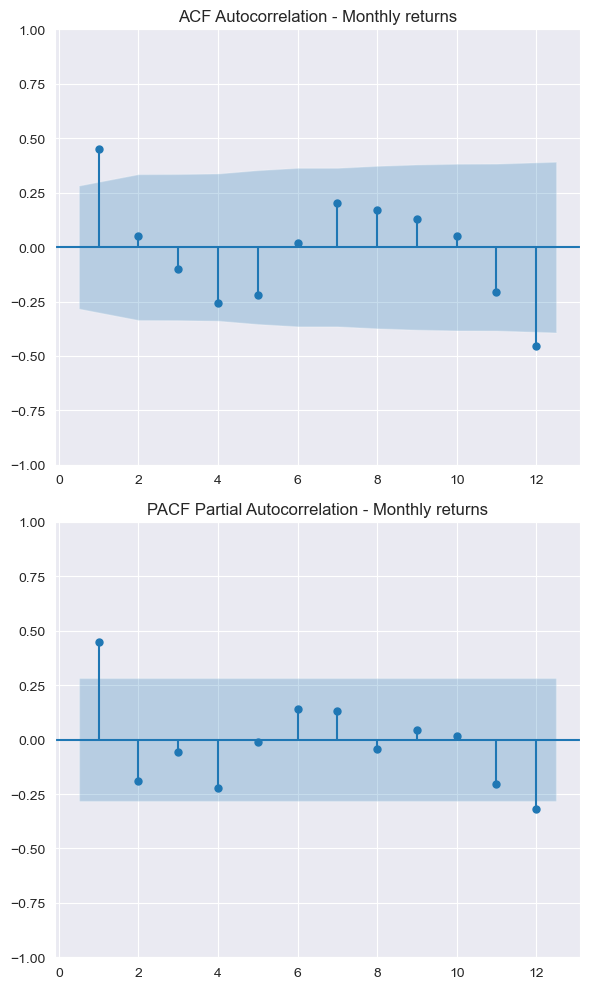

In [130]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1, figsize=(6,10))

marketstack_diff = marketstack_month.diff()

# Plot the ACF
ax1 = tsaplots.plot_acf(marketstack_diff['2020': '2023']['GT'], 
                  lags=12, 
                  zero=False, 
                  alpha=0.05, 
                  ax=axes[0])
axes[0].title.set_text('ACF Autocorrelation - Monthly returns')

# Plot the PACF
tsaplots.plot_pacf(marketstack_diff['2020': '2023']['GT'], 
                  lags=12, 
                  zero=False, 
                  alpha=0.05, 
                  ax=axes[1])
axes[1].title.set_text('PACF Partial Autocorrelation - Monthly returns')
plt.tight_layout()

> No plot is trailing off, and both show a seasonal pattern. This is thus either a ARMA model or seasonal

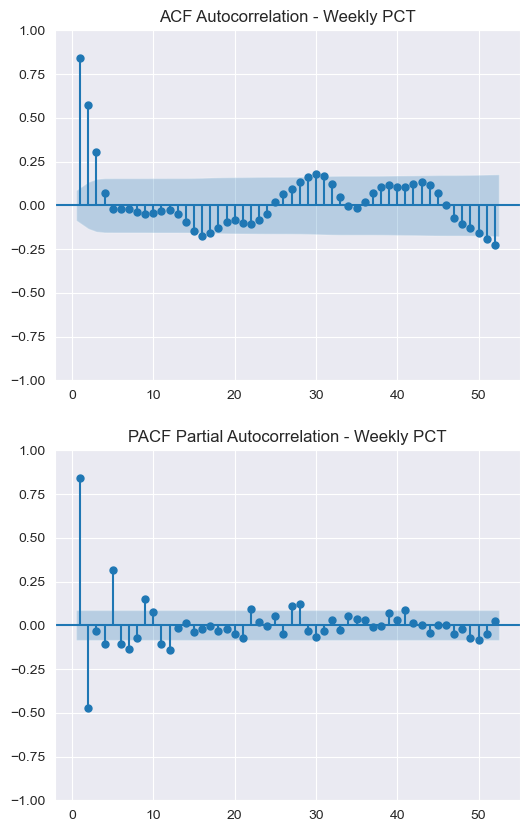

In [132]:
fig, axes = plt.subplots(2,1, figsize=(6,10))

tsaplots.plot_acf(pct_weekly, 
                  zero=False, 
                  lags=52, 
                  alpha=0.05,
                  ax=axes[0])
axes[0].title.set_text('ACF Autocorrelation - Weekly PCT')

tsaplots.plot_pacf(pct_weekly, 
                   zero=False, 
                   lags=52, 
                   alpha=0.05,
                   ax=axes[1])

axes[1].title.set_text('PACF Partial Autocorrelation - Weekly PCT')
plt.show()

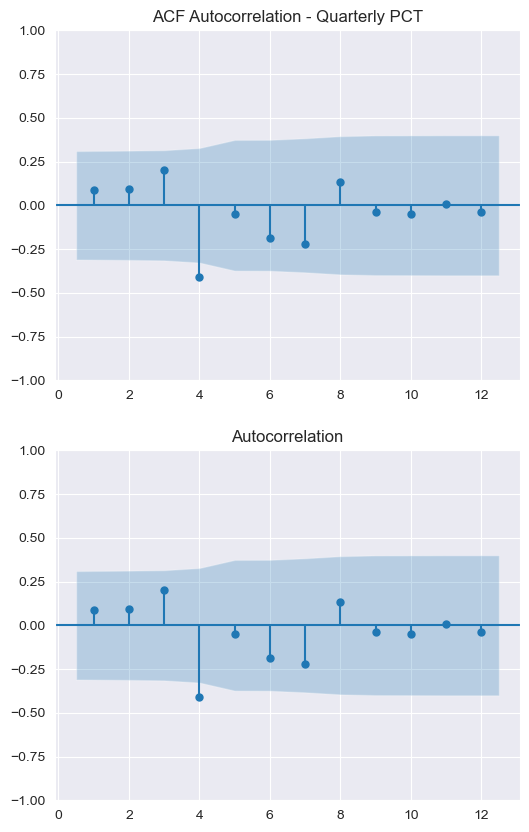

In [133]:
fig, axes = plt.subplots(2,1, figsize=(6,10))
tsaplots.plot_acf(pct_quarterly, 
                  zero=False, 
                  lags=12, 
                  alpha=0.05,
                  ax=axes[0])
axes[0].title.set_text('ACF Autocorrelation - Quarterly PCT')

tsaplots.plot_acf(pct_quarterly, 
                  zero=False,
                  lags=12, 
                  alpha=0.05,
                  ax=axes[1])
axes[0].title.set_text('ACF Autocorrelation - Quarterly PCT')
plt.show()


> Lag 4 (quarter 4) is significant


**Conclusion**
None of ACF or PACF tails off, so this means we have a ARMA model
We have to do find lowest BIC or AIC to find the best model parameters


## Step x:  How to know which order to use ?

**1. AIC and BIC**

In the last lesson, we mentioned how ACF and PACF can't be used to choose the order of a model, when both of the orders p and q are non-zero. However there are more tools we can use, the AIC and the BIC.

**2. AIC - Akaike information criterion**

The Akaike information criterion, or AIC, is a metric which tells us how good a model is. A model which makes better predictions is given a lower AIC score. The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data.

**3. BIC - Bayesian information criterion**

The Bayesian information criterion, or BIC, is very similar to the AIC. Models which fit the data better have lower BICs and the BIC penalizes overly complex models.

**4. AIC vs BIC**

For both of these metrics a lower value suggests a better model. The difference between these two metrics is how much they penalize model complexity. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However if our goal is to identify a good explanatory model, we should use BIC.




In [134]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(12):
  # Loop over q values from 0-2
    for q in range(12):
        
        try:
            
            # create and fit ARMA(p,q) model
            model = ARIMA(marketstack_diff['2020':'2024']['GT'], order=(p,0,q))
            results = model.fit()
        
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
            
        except:
            order_aic_bic.append((p,q, None, None))

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

In [135]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

      p   q         AIC         BIC
1     0   1  183.455901  189.191970
12    1   0  185.038182  190.774251
14    1   2  185.062298  194.622413
24    2   0  185.228088  192.876180
13    1   1  185.271744  192.919836
..   ..  ..         ...         ...
95    7  11  204.651371  242.891831
119   9  11  204.895903  246.960409
118   9  10  205.104376  245.256860
130  10  10  206.180762  248.245268
131  10  11  207.447223  251.423752

[144 rows x 4 columns]


In [136]:
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

      p   q         AIC         BIC
1     0   1  183.455901  189.191970
12    1   0  185.038182  190.774251
24    2   0  185.228088  192.876180
13    1   1  185.271744  192.919836
2     0   2  185.298447  192.946539
..   ..  ..         ...         ...
142  11  10  202.222655  246.199184
119   9  11  204.895903  246.960409
130  10  10  206.180762  248.245268
143  11  11  203.169289  249.057841
131  10  11  207.447223  251.423752

[144 rows x 4 columns]


# Step 3: Which AR model is best ?

## Autoregressive (AR) Models

The statsmodels class ARMA has been deprecated and replaced with the slightly more general ARIMA class. After importing ARIMA, create an instance of that class called mod, with the arguments being the data that you're trying to fit, and the order of the model. 

The order (1,0,0) means you're fitting the data to an AR(1) model with only 1 lag. An order (2,0,0) would mean you're fitting the data to an AR(2) model with 2 lags. 

The middle number, d, relates to whether you take first differences of the data to make the time series stationary, like you would do with a random walk. For now, we'll assume there are no first differences so the middle number will be zero.
  degree of differences is the number of time you need to call .diff().diff() to make it stationary.

In the last chapter, we will give an example where we do take first differences. The third number, q, is the MA part, which will be discussed in the next chapter. Once you instantiate the class, you can use the method fit to estimate the model, and store the results in result.

In [ ]:
# simulate ARMA data
from statsmodels.tsa.arima_process import arma_generate_sample

fig, axes = plt.subplots(3,3, figsize=(18,8))
ar_coefs = [1, -0.1]
ma_coefs = [1, 0]
y1 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax1 = sns.lineplot(y1, ax=axes[0,0])
ax1.set_title('AR model with coef {}'.format(ar_coefs[1]))

ar_coefs = [1, -0.5]
ma_coefs = [1, 0]
y2 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax2 = sns.lineplot(y2, ax=axes[0,1])
ax2.set_title('AR model with coef {}'.format(ar_coefs[1]))

ar_coefs = [1, -0.9]
ma_coefs = [1, 0]
y3 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax3 = sns.lineplot(y3, ax=axes[0,2])
ax3.set_title('AR model with coef {}'.format(ar_coefs[1]))

ar_coefs = [1, 0]
ma_coefs = [1, 0.1]
y4 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax4 = sns.lineplot(y4, ax=axes[1,0])
ax4.set_title('MA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, 0]
ma_coefs = [1, 0.5]
y5 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax5 = sns.lineplot(y5, ax=axes[1,1])
ax5.set_title('MA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, 0]
ma_coefs = [1, 0.9]
y6 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax6 = sns.lineplot(y6, ax=axes[1,2])
ax6.set_title('MA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, -0.1]
ma_coefs = [1, 0.1]
y7 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax7 = sns.lineplot(y7, ax=axes[2,0])
ax7.set_title('ARMA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, -0.5]
ma_coefs = [1, 0.5]
y8 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax8 = sns.lineplot(y8, ax=axes[2,1])
ax8.set_title('ARMA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, -0.9]
ma_coefs = [1, 0.9]
y9 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax9 = sns.lineplot(y9, ax=axes[2,2])
ax9.set_title('ARMA model with coef {}'.format(ma_coefs[1]))

plt.suptitle('Sample ARMA data to understand the different distributions and impact')
plt.tight_layout()

In [ ]:
# Fit an AR model with monthly stock market data

# Instantiate the model
model = ARIMA(marketstack_diff['2014':'2023']['GT'], order=(9,0,2))
results = model.fit()

# Print out summary information on the fit
print(results.summary())

# Print out the estimate for phi
print("Estimate of L1 phi is: {}".format(results.params.iloc[1]))

In [ ]:
# generate in-sample forecasts, using the last steps of training data

# make predictions for last 25 entries of training data
forecast = results.get_prediction(start=-36, dynamic=False)

# extract predicted forecasts, in our case by month
mean_forecast = forecast.predicted_mean

# get confidence levels of predictions
confidence_intervals = forecast.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1)
# plot actuals
sns.lineplot(marketstack_diff['2020':'2023']['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(mean_forecast,
             color='red',
             label='forecast',
             ax=axes)

# shade uncertainty 
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.show()


In [ ]:
# with ARIMA, we can also use non-stationary series to predict the actual stock value and not the difference.

# Instantiate the model
model = ARIMA(marketstack_ma_month['2014':'2023']['GT'], order=(9,1,2))
results = model.fit()

# Print out summary information on the fit
print(results.summary())

# make predictions for last 25 entries of training data
forecast = results.get_prediction(start=-36, dynamic=False)
# forecast = results.get_forecast(steps=12)

# extract predicted forecasts, in our case by month
mean_forecast = forecast.predicted_mean

# get confidence levels of predictions
confidence_intervals = forecast.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1)
# plot actuals
sns.lineplot(marketstack_ma_month['2020':'2023']['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(mean_forecast,
             color='red',
             label='forecast',
             ax=axes)

# shade uncertainty 
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.show()

## Step x: Model diagnostics

Before we use the model to predict, we want to know how good the model predictions are.
MAE is a good measure for this - mean difference between predictions and true values

In [ ]:
# extract the errors (residuals)
residuals = results.resid

# calcalte the mean absolute error
mae = np.mean(np.abs(residuals))
print('MAE: {}'.format(mae))


#### plot_diagostics:
- plot 1: there should be no obvious structure in residuals
- plot 2: distribution of residuals should be normalized. If model is good orange and green lines should be close together
- plot 3: compare distribution of model residuals to a normal distribution, all the residuals should lie along the red line
- plot 4: correlogram - ACF plot using residuals. 95% of correlations for lag > 0 should not be significant.

In [ ]:
# For an ideal model, the residuals shoudl be uncorrelat3eed white Gaussian noice centered on zero
results.plot_diagnostics()
plt.show()

#### Summary statistics
- Prob(Q) - Ljung-Box: pvalue associated with the null hypothesis that the residuals have no correlation structure. 
- Prob(JB) - Jarque Bera: pvalue for null hypothesis that residuals are normal
    
If either p_value < 0.05, this is bad, and we should reject the null hypothesis, and go back and improve our modelling.

**Example from datacamp exercise: **
Great! The JB p-value is zero, which means you should reject the null hypothesis that the residuals are normally distributed. However, the histogram and Q-Q plots show that the residuals look normal. This time the JB value was thrown off by the one outlying point in the time series. In this case, you could go back and apply some transformation to remove this outlier or you probably just continue to the production stage.

In [ ]:
print(results.summary())



**Conclusion**:
With Prod(JB) < 0.05 we reject the null hypothis that residuals are normally distributed.
There might be some outliers, like with huge drop 2018-2020, some more transformations might be needed.

Since the data is seasonal we will always have correlated residuals left if we try to fit an ARIMA model to it. This means that we aren't using all of the information in the data, and so we aren't making the best predictions possible

# Box-Jenkins methods
It's a methodology to follow to build the best ARIMA models

1) Identification
- Is the time series stationary ?
- What differencing will make it stationary ?
- What transforms will make it statiionary ?
- What values of p and q are most promising ?
- We use: df.plot, adfuller(), .didff(), np.log(), np.sqrt(), plot_acf, plot_pacf

2) Estimation
- model.fit()
- results.aic, results.bic 

3) model diagostics
- results.plot_diagnostics()
- results.summary()

4) model ok ?

5) make forecasts / production

# Step x: Prediction

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
marketstack_ma_month['2020':'2026']['GT'].plot(ax=ax)
fig = plot_predict(results, start='2020', end='2026', alpha=0.05, ax=ax, dynamic=False)
plt.show() 

# Step x: Seasonality

SARIMA model
- It's like fitting 2 models, one for seasonal part, and another for non-seasonal part

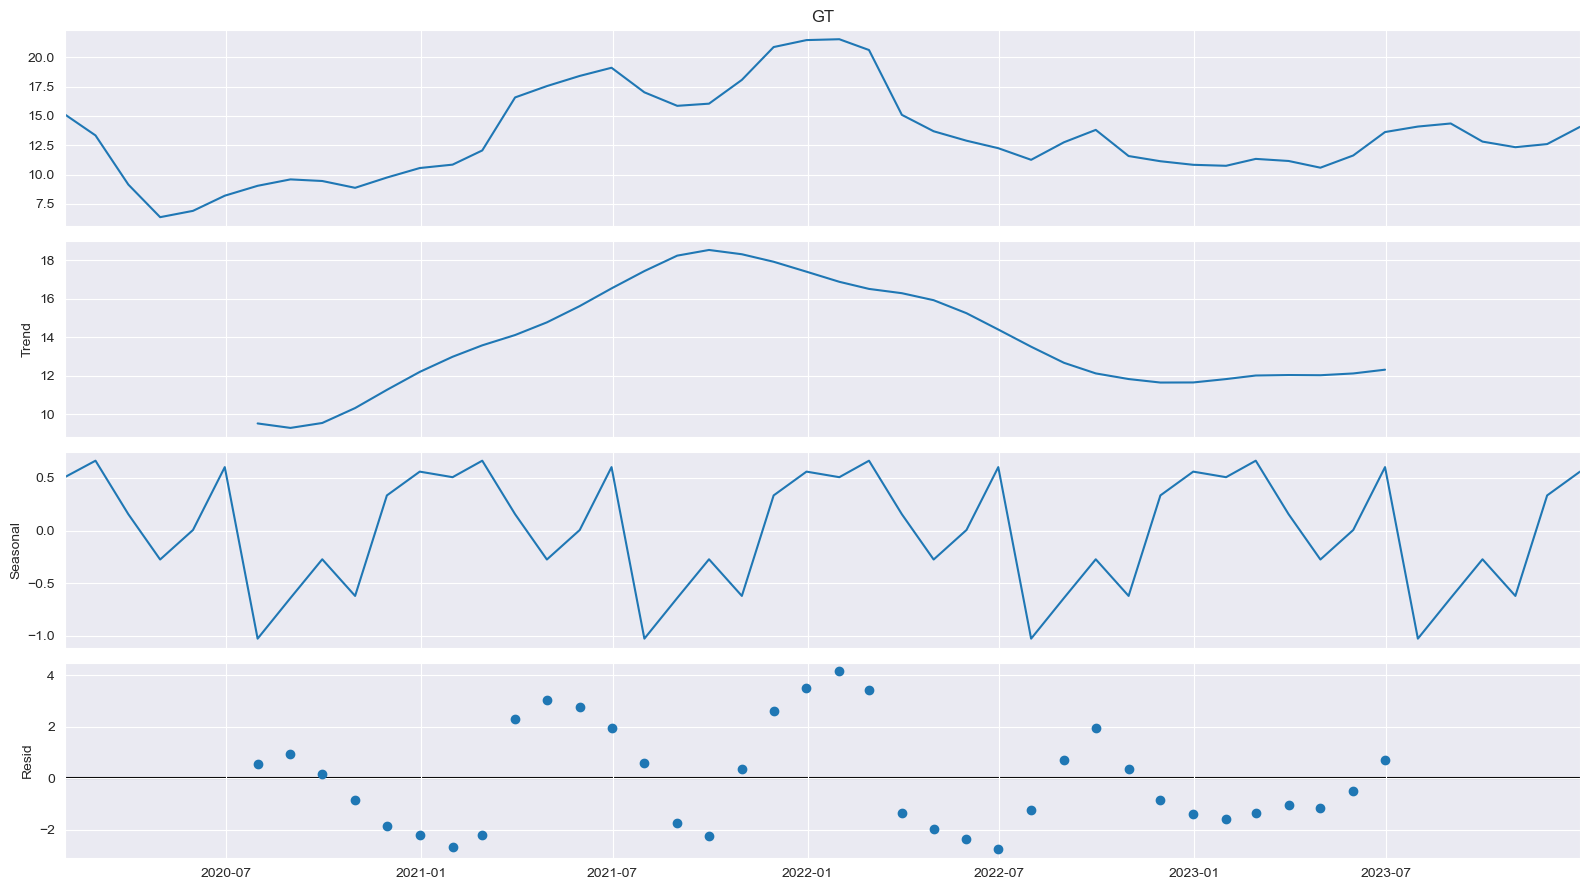

In [138]:
decomposition = sm.tsa.seasonal_decompose(
    marketstack_month['GT']['2020':'2023'],
    period=12,
    # model='multiplicative'
)
fig = decomposition.plot()
fig.set_size_inches((16, 9))
plt.tight_layout()

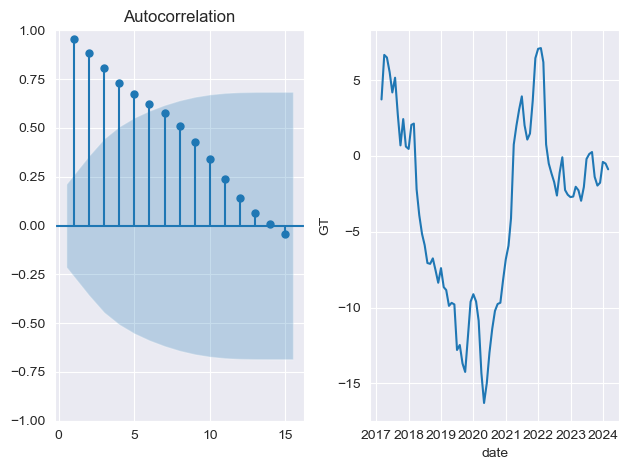

In [140]:
test = marketstack_month - marketstack_month.rolling(36).mean()
test = test.dropna()
# Create figure and subplots
fig, axes = plt.subplots(1, 2)

sns.lineplot(test['GT'], ax=axes[1])

# Plot the ACF
plot_acf(test['GT'], lags=15, zero=False, ax=axes[0])

# Show figure
plt.tight_layout()

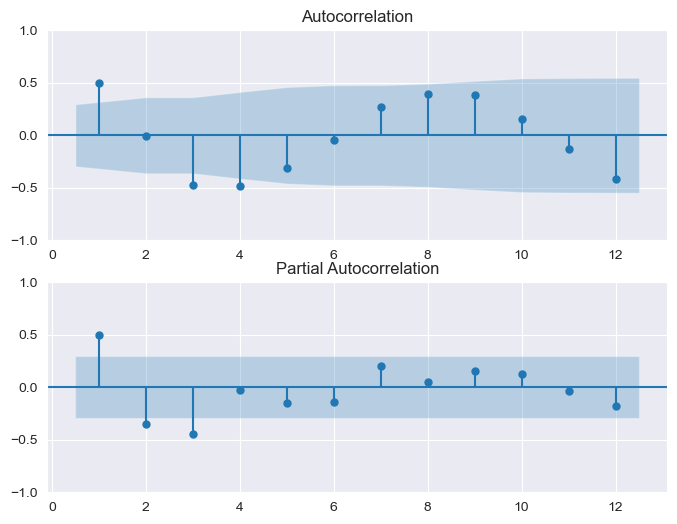

In [146]:
# create non-seasonal and seasonal ACF and PACF plots and use the table below to choose the appropriate model orders.

# Take the first and seasonal differences and drop NaNs
test = marketstack_month['GT']['2020':'2023'].diff().diff(3).dropna()
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(test, lags=12, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(test, lags=12, zero=False, ax=ax2)

plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 36 must be < 22.

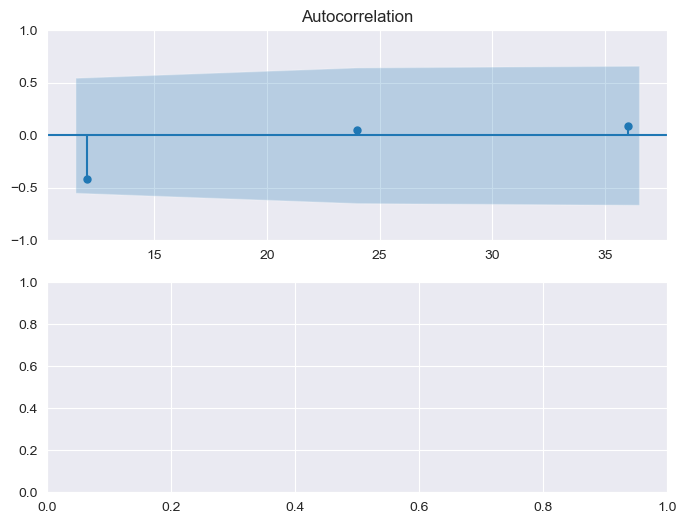

In [145]:
# Seasonal ACF, PACF
seasonal_lags = [12, 24, 36]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(test, lags=seasonal_lags, ax=ax1)

# Plot the PACF on ax2
plot_pacf(test, lags=seasonal_lags, ax=ax2)

plt.show()

> PACF tails off, whilst ACF cuts off after lag 12

The non-seasonal ACF doesn't show any of the usual patterns of MA, AR or ARMA models so we choose none of these. The Seasonal ACF and PACF look like an MA(1) model. We select the model that combines both of these, being (0,1,0, 0.1.1,12)

In [161]:
prediction_results = forecast.prediction_results.results
prediction_results

model = SARIMAX(df, order=(), seasonal_order())
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88697D+00    |proj g|=  1.92923D-01

At iterate    5    f=  1.78495D+00    |proj g|=  6.65823D-03

At iterate   10    f=  1.78200D+00    |proj g|=  6.28339D-03

At iterate   15    f=  1.78149D+00    |proj g|=  1.06666D-03

At iterate   20    f=  1.78143D+00    |proj g|=  8.03174D-04

At iterate   25    f=  1.78142D+00    |proj g|=  1.23275D-04

At iterate   30    f=  1.78142D+00    |proj g|=  4.32969D-04

At iterate   35    f=  1.78142D+00    |proj g|=  1.04751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

TypeError: 'SmootherResults' object is not iterable

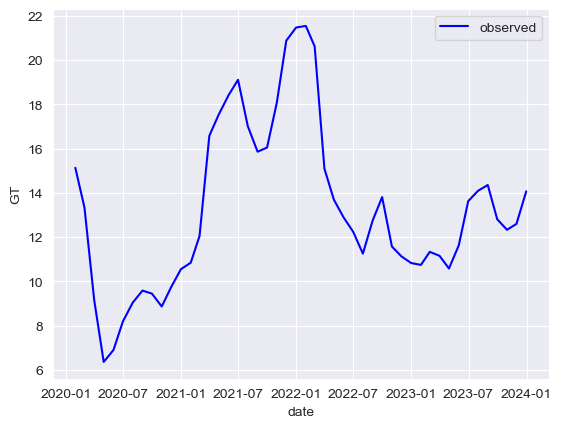

In [162]:
## Instantiate the model
model = SARIMAX(endog=marketstack_month['2014':'2023']['GT'], 
                order=(0,1,2),
                seasonal_order=(0,1,1,12),
                )
results = model.fit()

# Print out summary information on the fit
# print(results.summary())

# # make predictions for last 25 entries of training data
forecast = results.get_prediction(start=-36, dynamic=False)
mean_forecast = forecast.predicted_mean
prediction_results = forecast.prediction_results.results

# get confidence levels of predictions
confidence_intervals = forecast.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1)

# plot actuals
sns.lineplot(marketstack_month['2020':'2023']['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(list(prediction_results),
             color='red',
             # label='forecast',
             ax=axes)

# shade uncertainty 
# plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.show()


In [ ]:
forecast = results.get_forecast(steps=24)
# extract predicted forecasts, in our case by month
mean_forecast = forecast.predicted_mean

# get confidence levels of predictions
confidence_intervals = forecast.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1)

# plot actuals
sns.lineplot(marketstack_ma_month['2020':'2023']['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(mean_forecast,
             color='red',
             label='forecast',
             ax=axes)

# shade uncertainty 
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.show()

Excellent! Time series data collected on a seasonal basis typically have mixed dependence. For example, what happens in June is often related to what happened in May as well as what happened in June of last year.

In [ ]:


# results of best model
results = pm.auto_arima(marketstack_ma_month['GT'],
                        seasonal=True,
                        d=1,
                        D=1,
                        m=12,
                        information_criterion='aic',
                        error_action='ignore',
                        # stepwise=True,
                        )
                        
print(results.summary())

In [ ]:
results.plot_diagnostics()

In [ ]:
# Import joblib
import joblib

# Set model name
filename = "sarima_model.pkl"

# Pickle it
joblib.dump(model, filename)

In [ ]:
# load back the model
model_results_object = joblib.load(filename)

# for later - updating the model
# model_results_object.update(df_new)

In [ ]:
# Create SARIMA mean forecast
sarima_pred = results.get_forecast(steps=25)
# sarima_mean = sarima_pred.predicted_mean
# 
# # Plot mean ARIMA and SARIMA predictions and observed
# plt.plot(dates, sarima_mean, label='SARIMA')
# plt.plot(marketstack_ma_month, label='observed')
# plt.legend()
# plt.show()

# References

https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/2
https://otexts.com/fpp2/seasonal-arima.html
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Time%20Series%20Forecastings.ipynb
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3